# Predicción de decisiones

Para ver el resumen del cuadernillo empezar por el final. \
Puedes ver el proceso de desarrollo y la toma de decisiones a lo largo de todo el cuadernillo.

In [ ]:
!pip install tsfresh
!pip install mrmr_selection

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.8/95.8 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.2/41.2 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.5/176.5 kB 3.6 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.13.1
    Uninstalling scipy-1.13.1:
      Successfully uninstalled scipy-1.13.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gensim 4.3.3 requires scipy<1.14.0,>=1.7.0, but you have scipy 1.14.1 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.0/82.0 kB 5.4 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import sys
sys.path.append('/content/drive/MyDrive/tfg/codigo')


Mounted at /content/drive


In [ ]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import matplotlib.dates as mdates
from datetime import datetime

# MNE for EEG processing
# import mne

# Scikit-learn for machine learning
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from IPython.display import Image
from IPython.core.display import HTML
import matplotlib.pyplot as plt
from scipy import signal
from tsfresh import extract_features
from tsfresh import select_features
from tsfresh.utilities.dataframe_functions import impute

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [ ]:
import procesamiento_datos as prd
import constantes

In [ ]:
# Set a random seed for reproducibility
random_seed = 25
np.random.seed(random_seed)
TASA_MUESTREO = 256 #Hz
stdout = sys.stdout

## Cargamos los datos

In [ ]:
#Drive
#Colab install libraries
# import os

#!python--version
#!ls /content/drive/MyDrive/tfg/codigo

ruta_datos = '/content/drive/My Drive/tfg/datos/Local'
os.chdir(ruta_datos)
idx_file = 4 #No tocar a no ser que solucione selección de características entre ficheros

archivos_local = os.listdir()
archivos_local.sort()
all_local_data = prd.juntar_datos(".")
single_local_data = prd.leer_datos(archivos_local[idx_file])

os.chdir("../" + constantes.DATA_DIR + constantes.MUSE_DATA)
archivos_muse = os.listdir()
archivos_muse.sort()
single_muse_data = prd.leer_datos(archivos_muse[idx_file])

In [ ]:
# print(archivos_local)
# print(archivos_muse)
print(os.getcwd())
print(os.listdir())
print(archivos_muse)
print("Archivo a analizar:", archivos_muse[idx_file])

/content/drive/MyDrive/tfg/datos/Muse
['museData19.csv', 'museData18.csv', 'museData17.csv', 'museData16.csv', 'museData15.csv', 'museData14.csv', 'museData13.csv', 'museData12.csv', 'museData11.csv', 'museData0.csv', 'museData1.csv', 'museData10.csv', 'museData8.csv', 'museData9.csv', 'museData7.csv', 'museData6.csv', 'museData5.csv', 'museData4.csv']
['museData0.csv', 'museData1.csv', 'museData10.csv', 'museData11.csv', 'museData12.csv', 'museData13.csv', 'museData14.csv', 'museData15.csv', 'museData16.csv', 'museData17.csv', 'museData18.csv', 'museData19.csv', 'museData4.csv', 'museData5.csv', 'museData6.csv', 'museData7.csv', 'museData8.csv', 'museData9.csv']
Archivo a analizar: museData12.csv


In [ ]:
# #Local
# ruta_datos = constantes.DATA_DIR + constantes.LOCAL_DATA
# os.chdir(ruta_datos)
# archivos_local = os.listdir()
# all_local_data = prd.juntar_datos(".")
# single_local_data = prd.leer_datos(archivos_local[0])

# os.chdir("../" + constantes.DATA_DIR + constantes.MUSE_DATA)
# archivos_muse = os.listdir()
# single_muse_data = prd.leer_datos(archivos_muse[0])


In [ ]:
all_local_data.head()


,ID del participante,Trial,Respuesta,Tiempo de inicio,Tiempo de aparición de letras,Tiempo de la pulsación,Tecla elegida,Tiempo de aparición de la letra observada,Letra observada
0,8,0,0,2023-4-23 12:21:36.404,2023-4-23 12:21:41.407,2023-4-23 12:21:43.356,q,2023-4-23 12:21:42.407,d
1,8,0,1,2023-4-23 12:21:44.949,2023-4-23 12:21:46.951,2023-4-23 12:21:49.741,p,2023-4-23 12:21:48.951,m
2,8,0,2,2023-4-23 12:21:50.849,2023-4-23 12:21:52.855,2023-4-23 12:21:56.310,q,2023-4-23 12:21:55.855,t
3,8,0,3,2023-4-23 12:21:57.929,2023-4-23 12:21:59.935,2023-4-23 12:22:2.428,q,2023-4-23 12:22:1.935,t
4,8,0,4,2023-4-23 12:22:3.864,2023-4-23 12:22:5.871,2023-4-23 12:22:12.121,q,2023-4-23 12:22:11.367,t


In [ ]:
all_local_data.describe()

,ID del participante,Trial,Respuesta
count,2579.000000,2579.000000,2579.000000
mean,9.346646,4.618457,7.528887
std,5.790032,2.946942,5.510150
min,0.000000,0.000000,0.000000
25%,5.000000,2.000000,3.000000
50%,9.000000,5.000000,7.000000
75%,15.000000,7.000000,11.000000
max,19.000000,11.000000,30.000000


A priori contamos con un total de 2579 respuestas.

In [ ]:
single_local_data.tail()

,ID del participante,Trial,Respuesta,Tiempo de inicio,Tiempo de aparición de letras,Tiempo de la pulsación,Tecla elegida,Tiempo de aparición de la letra observada,Letra observada
102,12,9,0,2023-5-2 21:57:39.57,2023-5-2 21:57:44.62,2023-5-2 21:58:5.563,q,2023-5-2 21:58:5.62,l
103,12,9,1,2023-5-2 21:58:7.159,2023-5-2 21:58:9.166,2023-5-2 21:58:18.919,p,2023-5-2 21:58:18.167,s
104,12,9,2,2023-5-2 21:58:21.1,2023-5-2 21:58:23.6,2023-5-2 21:58:39.344,q,2023-5-2 21:58:39.6,s
105,12,9,3,2023-5-2 21:58:41.85,2023-5-2 21:58:43.86,2023-5-2 21:59:6.608,p,2023-5-2 21:59:6.87,d
106,12,9,4,2023-5-2 21:59:9.755,2023-5-2 21:59:11.758,2023-5-2 21:59:20.822,q,2023-5-2 21:59:20.263,l


In [ ]:
single_muse_data.head()

,TimeStamp,Delta_TP9,Delta_AF7,Delta_AF8,Delta_TP10,Theta_TP9,Theta_AF7,Theta_AF8,Theta_TP10,Alpha_TP9,...,Gyro_X,Gyro_Y,Gyro_Z,HeadBandOn,HSI_TP9,HSI_AF7,HSI_AF8,HSI_TP10,Battery,Elements
0,2023-05-02 21:25:57.267,0.0,1.113182,0.472544,0.767179,0.0,0.682352,0.160541,1.092241,0.0,...,7.155304,-4.478607,-1.420593,1.0,2.0,1.0,1.0,2.0,100.0,NaN
1,2023-05-02 21:25:57.269,0.0,1.113182,0.472544,0.767179,0.0,0.682352,0.160541,1.092241,0.0,...,7.155304,-4.478607,-1.420593,1.0,2.0,1.0,1.0,2.0,100.0,NaN
2,2023-05-02 21:25:57.272,0.0,1.113182,0.472544,0.767179,0.0,0.682352,0.160541,1.092241,0.0,...,7.155304,-4.478607,-1.420593,1.0,2.0,1.0,1.0,2.0,100.0,NaN
3,2023-05-02 21:25:57.273,0.0,1.113182,0.472544,0.767179,0.0,0.682352,0.160541,1.092241,0.0,...,7.155304,-4.478607,-1.420593,1.0,2.0,1.0,1.0,2.0,100.0,NaN
4,2023-05-02 21:25:57.275,0.0,1.113182,0.472544,0.767179,0.0,0.682352,0.160541,1.092241,0.0,...,7.155304,-4.478607,-1.420593,1.0,2.0,1.0,1.0,2.0,100.0,NaN


In [ ]:
all_local_data.columns

Index(['ID del participante', 'Trial', 'Respuesta', 'Tiempo de inicio',
       'Tiempo de aparición de letras', 'Tiempo de la pulsación', 'Tecla elegida',
       'Tiempo de aparición de la letra observada', 'Letra observada'],
      dtype='object')

In [ ]:
single_muse_data.columns

Index(['TimeStamp', 'Delta_TP9', 'Delta_AF7', 'Delta_AF8', 'Delta_TP10', 'Theta_TP9', 'Theta_AF7',
       'Theta_AF8', 'Theta_TP10', 'Alpha_TP9', 'Alpha_AF7', 'Alpha_AF8', 'Alpha_TP10', 'Beta_TP9',
       'Beta_AF7', 'Beta_AF8', 'Beta_TP10', 'Gamma_TP9', 'Gamma_AF7', 'Gamma_AF8', 'Gamma_TP10',
       'RAW_TP9', 'RAW_AF7', 'RAW_AF8', 'RAW_TP10', 'AUX_RIGHT', 'Mellow', 'Concentration',
       'Accelerometer_X', 'Accelerometer_Y', 'Accelerometer_Z', 'Gyro_X', 'Gyro_Y', 'Gyro_Z',
       'HeadBandOn', 'HSI_TP9', 'HSI_AF7', 'HSI_AF8', 'HSI_TP10', 'Battery', 'Elements'],
      dtype='object')

In [ ]:
single_muse_data.describe()

,Delta_TP9,Delta_AF7,Delta_AF8,Delta_TP10,Theta_TP9,Theta_AF7,Theta_AF8,Theta_TP10,Alpha_TP9,Alpha_AF7,...,Accelerometer_Z,Gyro_X,Gyro_Y,Gyro_Z,HeadBandOn,HSI_TP9,HSI_AF7,HSI_AF8,HSI_TP10,Battery
count,5.190000e+05,5.190000e+05,5.190000e+05,5.190000e+05,5.190000e+05,5.190000e+05,5.190000e+05,5.190000e+05,5.190000e+05,5.190000e+05,...,519000.000000,519000.000000,519000.000000,519000.000000,519000.000000,519000.000000,519000.000000,519000.000000,519000.000000,519000.0
mean,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,...,0.904089,4.201248,1.419223,3.707865,0.992385,1.749303,1.081642,1.093368,1.339037,100.0
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.221811,25.785155,18.340226,16.877887,0.086929,0.890639,0.458919,0.501447,0.565398,0.0
min,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,...,-1.874817,-243.743896,-240.214844,-230.637054,0.000000,1.000000,1.000000,1.000000,1.000000,100.0
25%,0.000000e+00,1.480944e-01,7.345164e-02,3.844789e-01,0.000000e+00,-1.309373e-01,-1.791536e-01,1.960823e-01,0.000000e+00,1.309839e-01,...,0.909302,4.448700,-1.757050,3.319702,1.000000,1.000000,1.000000,1.000000,1.000000,100.0
50%,3.923523e-01,4.504067e-01,4.316474e-01,6.127695e-01,1.739059e-01,8.413594e-02,1.853423e-02,3.814610e-01,3.787880e-01,3.016828e-01,...,0.942078,5.293579,-0.433655,4.658051,1.000000,2.000000,1.000000,1.000000,1.000000,100.0
75%,7.955435e-01,7.439148e-01,7.428557e-01,9.035572e-01,4.673899e-01,3.698386e-01,3.503976e-01,5.967665e-01,7.241698e-01,4.697728e-01,...,0.967285,6.123505,0.986938,6.078644,1.000000,2.000000,1.000000,1.000000,2.000000,100.0
max,4.004391e+00,2.994362e+00,2.745365e+00,3.984115e+00,3.050768e+00,2.046998e+00,1.832496e+00,3.012996e+00,2.998434e+00,2.452466e+00,...,1.870178,243.983154,242.173767,230.068817,1.000000,4.000000,4.000000,4.000000,4.000000,100.0


## Limpieza de datos

In [ ]:
#Resumen del preprocesamiento de datos (incluye algunas partes de las siguientes secciones)
def preprocesamiento(single_muse_data, single_local_data, ms_prev = 800, ms_post = 200, low_per=0.01, high_per=0.925, per_miss_val=0.2, umbr_inf=None, umbr_sup=None):
    single_muse_data.replace([np.inf, -np.inf], np.nan,).describe()

    raw_data = single_muse_data[['TimeStamp', 'RAW_AF7', 'RAW_AF8']]
    raw_data['TimeStamp'] = (pd.to_datetime(raw_data['TimeStamp']))

    ventanas, y_ventanas = extraer_ventanas_todas(single_local_data, raw_data, ms_prev, ms_post, low_per, high_per, per_miss_val, umbr_inf, umbr_sup)

    ventanas = np.array(ventanas) # Perdemos las etiquetas
    ventanas = np.insert(ventanas, 0, 0, axis=2)
    for idx, ventana in enumerate(ventanas):
        ventana[:,0] = idx
    ventanas = pd.DataFrame(data=ventanas.reshape(-1, 4), columns=['id', 'TimeStamp', 'RAW_AF7', 'RAW_AF8'])
    ventanas = ventanas.astype({'id':'int32', 'RAW_AF7':'float32', 'RAW_AF8':'float32'})

    y_ventanas = pd.Series(y_ventanas)
    y_ventanas = y_ventanas.map({'p':0, 'q':1})

    return ventanas, y_ventanas

Podemos ver que hay muchos valores NaN e infinitos.
Vamos a reemplazar los infinitos por NaN para posteriormente eliminar los NaN

In [ ]:
single_muse_data.replace([np.inf, -np.inf], np.nan,).describe()

,Delta_TP9,Delta_AF7,Delta_AF8,Delta_TP10,Theta_TP9,Theta_AF7,Theta_AF8,Theta_TP10,Alpha_TP9,Alpha_AF7,...,Accelerometer_Z,Gyro_X,Gyro_Y,Gyro_Z,HeadBandOn,HSI_TP9,HSI_AF7,HSI_AF8,HSI_TP10,Battery
count,498364.000000,514346.000000,511642.000000,511330.000000,498364.000000,514346.000000,511642.000000,511330.000000,498364.000000,514346.000000,...,519000.000000,519000.000000,519000.000000,519000.000000,519000.000000,519000.000000,519000.000000,519000.000000,519000.000000,519000.0
mean,0.465444,0.448905,0.434369,0.644077,0.276743,0.133557,0.109595,0.426561,0.422794,0.297879,...,0.904089,4.201248,1.419223,3.707865,0.992385,1.749303,1.081642,1.093368,1.339037,100.0
std,0.474706,0.429220,0.447407,0.383889,0.339638,0.358752,0.380501,0.337085,0.394978,0.318386,...,0.221811,25.785155,18.340226,16.877887,0.086929,0.890639,0.458919,0.501447,0.565398,0.0
min,-0.597366,-0.949812,-0.920145,-0.622432,-0.483130,-1.133696,-0.887789,-0.654053,-0.080295,-0.524363,...,-1.874817,-243.743896,-240.214844,-230.637054,0.000000,1.000000,1.000000,1.000000,1.000000,100.0
25%,0.000000,0.157065,0.087188,0.402862,0.000000,-0.130937,-0.165783,0.207828,0.000000,0.137946,...,0.909302,4.448700,-1.757050,3.319702,1.000000,1.000000,1.000000,1.000000,1.000000,100.0
50%,0.429478,0.457753,0.439432,0.616739,0.197650,0.090995,0.027647,0.388704,0.408013,0.306648,...,0.942078,5.293579,-0.433655,4.658051,1.000000,2.000000,1.000000,1.000000,1.000000,100.0
75%,0.812345,0.747145,0.752735,0.906980,0.479668,0.374519,0.360271,0.597303,0.739729,0.471509,...,0.967285,6.123505,0.986938,6.078644,1.000000,2.000000,1.000000,1.000000,2.000000,100.0
max,4.004391,2.994362,2.745365,3.984115,3.050768,2.046998,1.832496,3.012996,2.998434,2.452466,...,1.870178,243.983154,242.173767,230.068817,1.000000,4.000000,4.000000,4.000000,4.000000,100.0


Vamos a analizar la calidad de los canales según el valor HSI

In [ ]:
# sensores = ['HSI_TP9', 'HSI_AF7', 'HSI_AF8', 'HSI_TP10']
# media_sensores = []
# for file in archivos_muse:
#     current_file = prd.leer_datos(file)
#     # print("---------------------------------------------")
#     # print(current_file[sensores].mean())
#     media_sensores.append(current_file[sensores].mean())

In [ ]:
# np_md = np.array(media_sensores)
# print(np_md)
# tp9_and_tp10_fail = (np.where((np_md[:,0] > 2) & (np_md[:,3] > 2)))
# tp9_or_tp10_fail = (np.where((np_md[:,0] > 2) | (np_md[:,3] > 2)))

In [ ]:
# print(tp9_and_tp10_fail[0].size/len(archivos_muse) * 100)
# print(tp9_or_tp10_fail[0].size/len(archivos_muse) * 100)

Podemos ver que los sensores AF7 y AF8 no tienen casi ningún problema a lo largo de todos los experimentos. En cambio TP9 y TP10 suelen presentar más errores o datos de peor calidad ya que un valor HSI igual a 4 significa que los datos no son fiables, un valor de 2 significa que son aceptables y por último 1 significa que son buenos. En el 61% de los archivos la media de la calidad del sensor TP9 y TP10 es superior a 2, en el 72% de los casos, uno de los dos sensores tiene una media superior a 2. Por este motivo, vamos a descartar directamente estos sensores de todo el experimento.

Voy a realizar todo el procedimiento el extracción de características sobre un único dato para agilizar el desarrollo y posteriormente antes de llegar a la fase de selección de modelos y entrenamiento realizaré la manipulación diseñada sobre todo el conjunto de datos.

In [ ]:
raw_data = single_muse_data[['TimeStamp', 'RAW_AF7', 'RAW_AF8', 'HSI_AF7', 'HSI_AF8']]
# raw_data = single_muse_data[['TimeStamp', 'RAW_TP9', 'RAW_AF7', 'RAW_AF8', 'RAW_TP10', 'HSI_TP9', 'HSI_AF7', 'HSI_AF8', 'HSI_TP10']]
# raw_data.concat(single_muse_data.loc[:, "RAW_TP9":"RAW_TP10"])

In [ ]:
raw_data['TimeStamp'] = (pd.to_datetime(raw_data['TimeStamp']))

<ipython-input-22-13e6c4c9d3b9>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw_data['TimeStamp'] = (pd.to_datetime(raw_data['TimeStamp']))


In [ ]:
print(type(raw_data['TimeStamp'][0]))
raw_data.dtypes

<class 'pandas._libs.tslibs.timestamps.Timestamp'>


,0
TimeStamp,datetime64[ns]
RAW_AF7,float64
RAW_AF8,float64
HSI_AF7,float64
HSI_AF8,float64


In [ ]:
raw_data.head()

,TimeStamp,RAW_AF7,RAW_AF8,HSI_AF7,HSI_AF8
0,2023-05-02 21:25:57.267,843.3333,830.4396,1.0,1.0
1,2023-05-02 21:25:57.269,828.4249,824.3956,1.0,1.0
2,2023-05-02 21:25:57.272,818.3516,821.9780,1.0,1.0
3,2023-05-02 21:25:57.273,820.7692,825.2015,1.0,1.0
4,2023-05-02 21:25:57.275,826.0073,828.8278,1.0,1.0


In [ ]:
raw_data.describe()

,TimeStamp,RAW_AF7,RAW_AF8,HSI_AF7,HSI_AF8
count,520311,512772.000000,512712.000000,519000.000000,519000.000000
mean,2023-05-02 21:42:50.715535104,794.338047,794.868601,1.081642,1.093368
min,2023-05-02 21:25:57.267000,0.000000,0.000000,1.000000,1.000000
25%,2023-05-02 21:34:24.084499968,785.714300,784.505500,1.000000,1.000000
50%,2023-05-02 21:42:50.928000,794.578740,793.772900,1.000000,1.000000
75%,2023-05-02 21:51:17.326500096,803.443240,803.846100,1.000000,1.000000
max,2023-05-02 21:59:44.216000,1649.597000,1650.000000,4.000000,4.000000
std,NaN,64.708451,63.820366,0.458919,0.501447


Visualización de outliers

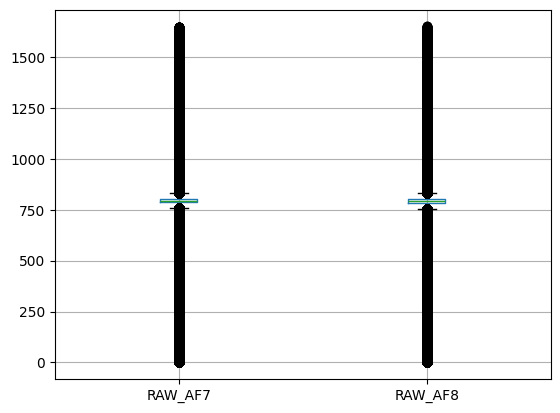

In [ ]:
raw_data[['RAW_AF7','RAW_AF8']].boxplot(); #; Elimina el texto de salida

Calculo el percentil 5|95 y 1|99 de los datos en crudo del fichero dado que utilizaré estos valores como umbrales. Descartaré un dato si el valor de alguno de los dos sensores se encuentra fuera del intervalo de los percentiles mencionados.

Inicialmente elegí 1|99 pero tras inventigar otros archivos he encontrado valores demasiados ruidosos, por lo que aumentaré umbral del percentil superior 92.5 para evitar valores del orden de 1e6 que impiden el entrenamiento de algunos modelos, mantendré el valor inferior.

In [ ]:
q005_8 = raw_data['RAW_AF8'].quantile(0.05)
q095_8 = raw_data['RAW_AF8'].quantile(0.95)
q005_7 = raw_data['RAW_AF7'].quantile(0.05)
q095_7 = raw_data['RAW_AF7'].quantile(0.95)

q005_f = (q005_7 + q005_8)/2
q095_f = (q095_7 + q095_8)/2
print(q005_f)
print(q095_f)
print("----------")
q001_8 = raw_data['RAW_AF8'].quantile(0.01)
q099_8 = raw_data['RAW_AF8'].quantile(0.99)
q001_7 = raw_data['RAW_AF7'].quantile(0.01)
q099_7 = raw_data['RAW_AF7'].quantile(0.99)

q001_f = (q001_7 + q001_8)/2
q099_f = (q099_7 + q099_8)/2
print(q001_f)
print(q099_f)
print("----------")
q005_8 = raw_data['RAW_AF8'].quantile(0.05)
q0925_8 = raw_data['RAW_AF8'].quantile(0.925)
q005_7 = raw_data['RAW_AF7'].quantile(0.05)
q0925_7 = raw_data['RAW_AF7'].quantile(0.925)

q005_f = (q005_7 + q005_8)/2
q0925_f = (q0925_7 + q0925_8)/2
# print(q005_f)
print(q001_f)
print(q0925_f)


756.70331
835.4762000000001
----------
652.9487300000001
921.50185
----------
652.9487300000001
825.6043999999999


Vamos a eliminar los filas con valores nulos.

In [ ]:
print(raw_data.isna().sum().sum())
print(raw_data.count())

17760
TimeStamp    520311
RAW_AF7      512772
RAW_AF8      512712
HSI_AF7      519000
HSI_AF8      519000
dtype: int64


Pero en lugar de hacerlo directamente sobre todos los datos del fichero lo haremos más adelante pero solo sobre las ventanas, reduciendo asi la cantidad de datos procesados.

In [ ]:
# raw_data.dropna()

A continuación vamos a extraer una ventana para la primera respuesta. Las ventanas son los datos dentro de un intervalo de tiempo. Para ello tenemos que buscar coger el tiempo de pulsación de los datos 'Local' y dado un tamaño de ventana seleccionar todos las entradas dentro de ese intervalo

Para el tamaño de la ventana vamos a utilizar 'ms_prev' milisegundos previos a la pulsación y 'ms_post' milisegundos posteriores a la pulsación.
También utilizaremos un umbral inferior y superior (low_th y high_th) para descartar los datos que se encuentre fuera de dicho intervalo, los umbrales irán definidos por los percetiles 1 y 99 de los valores en crudo.

In [ ]:
def extraer_ventana(single_muse_data, time_stamp, ms_prev, ms_post, low_th=740.0, high_th=855.0):
    tiempo_inicio = time_stamp - pd.Timedelta(milliseconds=ms_prev, unit='milliseconds')
    tiempo_fin = time_stamp + pd.Timedelta(milliseconds=ms_post, unit='milliseconds')

    ventana = single_muse_data[(single_muse_data['TimeStamp'] >= tiempo_inicio) & (single_muse_data['TimeStamp'] <= tiempo_fin)
                             & (single_muse_data['RAW_AF7'] >= low_th) & (single_muse_data['RAW_AF7'] <= high_th)
                             & (single_muse_data['RAW_AF8'] >= low_th) & (single_muse_data['RAW_AF8'] <= high_th)]


    #Filtro Notch en 50Hz
    samp_freq = TASA_MUESTREO  # Sample frequency 256 (Hz)
    notch_freq = 50.0  # Frequency to be removed from signal (Hz)
    quality_factor = 5.0  # Quality factor -> Indica el ancho de la banda, cuanto más alto, más estrecha es la banda y por lo tanto afecta a menos frecuencias cercanas y más a la frecuencia seleccionada. La presencia de ruido en la señal a eliminar puede afectar negativamente a valores de Q altos.
    b_notch, a_notch = signal.iirnotch(notch_freq, quality_factor, samp_freq)
    #Utilizamos el método de Gustaffson para evitar problemas con el padding.
    ventana['RAW_AF7'] = signal.filtfilt(b_notch, a_notch, ventana['RAW_AF7'], method="gust")
    ventana['RAW_AF8'] = signal.filtfilt(b_notch, a_notch, ventana['RAW_AF8'], method="gust")




#     ventana = single_muse_data.where((single_muse_data['TimeStamp'] >= tiempo_inicio))
#     mask = (single_muse_data['TimeStamp'] > tiempo_inicio) & (single_muse_data['TimeStamp'] <= tiempo_fin)
#     ventana = single_muse_data.loc((single_muse_data['TimeStamp'] >= tiempo_inicio))
#     print(single_muse_data['TimeStamp'].dtype)
#     print(type(tiempo_inicio), type(tiempo_fin))
#     print(tiempo_inicio)

    return ventana

In [ ]:
# tiempo_inicio = ts_prueba - pd.Timedelta(800, unit='milliseconds')
# tiempo_fin = ts_prueba + pd.Timedelta(200, unit='milliseconds')

# print(ts_prueba, tiempo_inicio, tiempo_fin)
# # ventana = raw_data[(raw_data['TimeStamp'] >= tiempo_inicio) & (raw_data['TimeStamp'] <= tiempo_fin)]
# # raw_data[(raw_data['TimeStamp'] >= tiempo_inicio) & (raw_data['TimeStamp'] <= tiempo_fin)]
# raw_data.head()

In [ ]:
  # ventana.head()

In [ ]:
ts_prueba = pd.to_datetime(single_local_data['Tiempo de la pulsación'][0])
ventana_prueba = extraer_ventana(raw_data, ts_prueba, 800, 200)
# print(ts_prueba)
# print(type(ts_prueba))
print(ventana_prueba.head())
print(ventana_prueba['RAW_AF7'].min())
print(ventana_prueba['RAW_AF7'].max())
# print(ventana_prueba.describe())

                   TimeStamp     RAW_AF7     RAW_AF8  HSI_AF7  HSI_AF8
3612 2023-05-02 21:26:11.126  804.576020  793.681977      1.0      1.0
3613 2023-05-02 21:26:11.127  788.341953  790.702866      1.0      1.0
3614 2023-05-02 21:26:11.128  776.020855  784.526960      1.0      1.0
3615 2023-05-02 21:26:11.129  779.215941  783.980250      1.0      1.0
3616 2023-05-02 21:26:11.130  789.973446  788.137456      1.0      1.0
774.3004658388026
804.5760199087449


<ipython-input-30-22f044032f48>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ventana['RAW_AF7'] = signal.filtfilt(b_notch, a_notch, ventana['RAW_AF7'], method="gust")
<ipython-input-30-22f044032f48>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ventana['RAW_AF8'] = signal.filtfilt(b_notch, a_notch, ventana['RAW_AF8'], method="gust")


Vamos a eliminar ahora los datos NaN de la ventana seleccionada.

In [ ]:
print(ventana_prueba.isna().sum().sum())
print(ventana_prueba.count())
ventana_prueba.dropna(inplace= True)
print(ventana_prueba.isna().sum().sum())
print(ventana_prueba.count())

0
TimeStamp    255
RAW_AF7      255
RAW_AF8      255
HSI_AF7      255
HSI_AF8      255
dtype: int64
0
TimeStamp    255
RAW_AF7      255
RAW_AF8      255
HSI_AF7      255
HSI_AF8      255
dtype: int64


<ipython-input-34-4d4a4adef8d9>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ventana_prueba.dropna(inplace= True)


In [ ]:
print(ventana_prueba.columns)

Index(['TimeStamp', 'RAW_AF7', 'RAW_AF8', 'HSI_AF7', 'HSI_AF8'], dtype='object')


## Visualización datos

Balance de clases 0(p)-1(q) en todos los ficheros

In [ ]:
# prd.balance_clases(os.getcwd())

Podemos ver que solo 4 archivos tienen un desbalance en los datos superior al 60% y que solo un sujeto, el 7, se presenta un desbalance del 70%

In [ ]:
def plot_eeg(window, title, idx_channel, ylabel="Tiempo (MM:SS.f)", time_format='%M:%S.%f'):
    # plt.figure(figsize=(12, 8))
    fig, ax = plt.subplots(figsize=(12,8))
    plt.plot(window['TimeStamp'], window.iloc[:, idx_channel], label=window.columns[idx_channel])
    ax.xaxis.set_major_formatter(mdates.DateFormatter(time_format))

    # Adding titles and labels
    plt.title(title)
    plt.xlabel(ylabel)
    plt.ylabel('Amplitud (µV)')
    plt.legend(loc='upper right')
    plt.show()

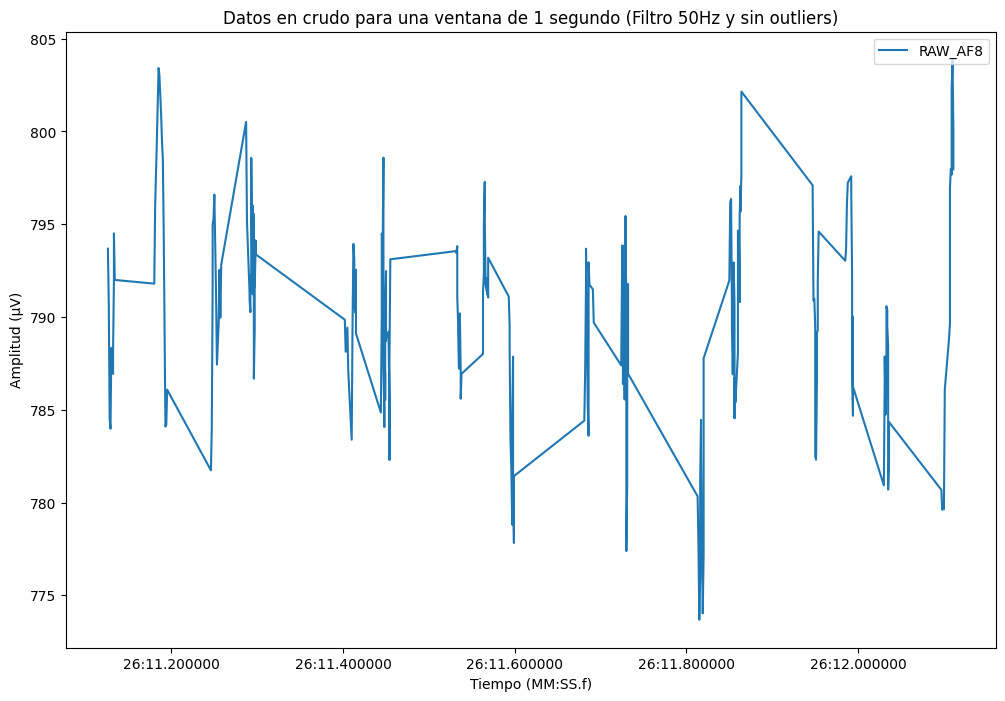

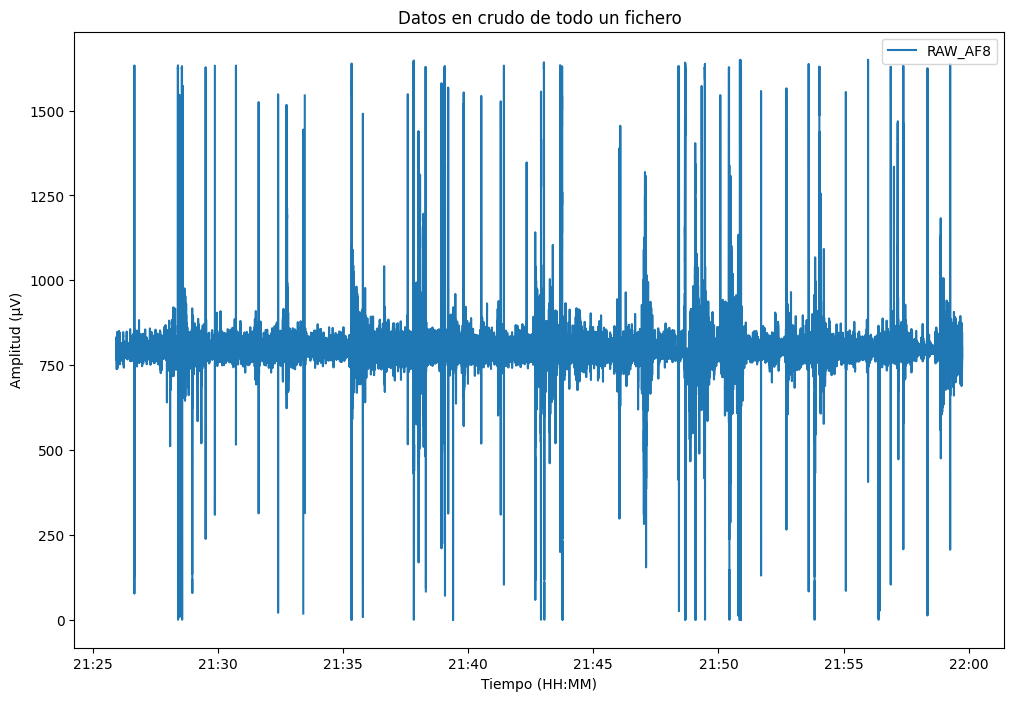

In [ ]:
plot_eeg(ventana_prueba, "Datos en crudo para una ventana de 1 segundo (Filtro 50Hz y sin outliers)",2)

plot_eeg(raw_data, "Datos en crudo de todo un fichero",2, ylabel="Tiempo (HH:MM)", time_format='%H:%M')

La visualización no es la típica señal que esperamos debido a que nuestros datos solo tienen valores en el intervalo {0-1682}. A continuación podemos ver como se suelen ver este tipo de señales.

De la gráfica de todos los datos en crudo y del describe() del dataset podemos concluir que los datos de mayor interés se encuentra entre 500 y 1000 micro voltios, el resto lo podemos considerar como valores atípicos, outliers y ruido, por ello deberiamos filtrar los datos y descartar dichos valores.

In [ ]:

# Fuente: http://www.chelseajin.com/blog/eeg
Image(url= "https://images.squarespace-cdn.com/content/v1/53fbefb1e4b01a33986e0cfc/1409757437358-63WXI9WHO2HXGX7N4E2A/image-asset.png?format=2500w")

### Transformada de Fourier

Vamos a ver que frecuencias estan presentes en la muestra extraida.

In [ ]:
def plot_fft(data, ylabel="Amplitud "):
    N = data.size
    T = 1/256 #Tasa de muestreo 256Hz
    # x = np.linspace(0.0, N*T, N)
    x = np.linspace(0.0, 1.0/(2.0*T), N//2+1)
    y = np.fft.rfft(data, norm="forward")
    # print(y)
    plt.ylabel("Amplitud (µV)")
    plt.xlabel("Frecuencia (Hz)")
    plt.ylim(-5,10)
    plt.plot(x,y)
    plt.show()

/usr/local/lib/python3.10/dist-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/usr/local/lib/python3.10/dist-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


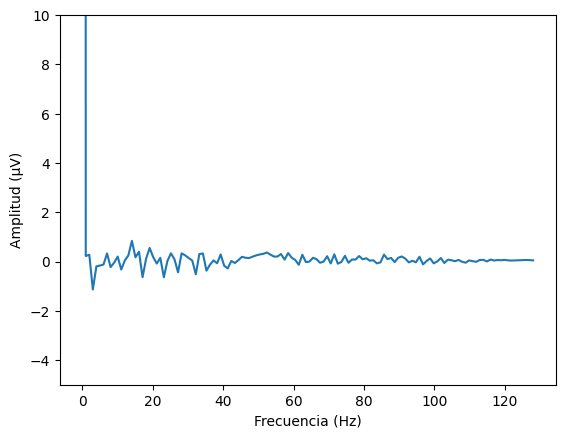

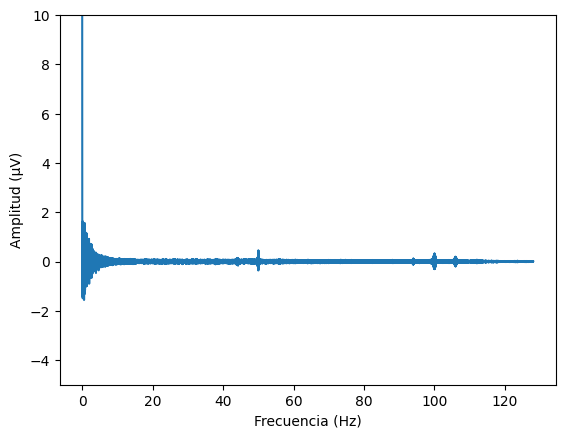

In [ ]:
plot_fft(ventana_prueba['RAW_AF7'].dropna())
# plt.cla()
plot_fft(raw_data['RAW_AF7'].dropna())
# print(y)
# N = ventana_prueba['RAW_AF7'].dropna().size
#     T = 1/256 #Tasa de muestreo 256Hz
#     # x = np.linspace(0.0, N*T, N)
#     x = np.linspace(0.0, 1.0/(2.0*T), N//2+1)
#     y = np.fft.rfft(ventana_prueba['RAW_AF7'].dropna(), norm="forward")
#     plt.ylim(-10,30)
#     plt.plot(x,y)
# print(ventana_prueba['RAW_AF7'])
# print(ventana_prueba['RAW_AF7'].describe())
# print(ventana_prueba['RAW_AF7'].dropna().describe())
# print(ventana_prueba['RAW_AF7'].dropna())
# print(ventana_prueba['RAW_AF7'].size)
# print(ventana_prueba['RAW_AF7'].dropna().size)

En las imágenes anteriores podemos ver la Transformada de Fourier Discreta para los datos del primer fichero.
La primera gráfica muestra la transformada para la ventana de 1 segundo situada en la primera respuesta.
La segunda gráfica es la transformada sobre todos los datos del primer fichero.
En ambos casos podemos ver que se detecta perfectamente una frecuencia de 50Hz. Me llama la atención porque precisamente 50Hz es la frecuencia a la que aparece ruido generado por la red eléctrica, aunque en principio los datos ya cuentan con un filtro Notch para solventar este problema. Otro posible motivo sea que al estar los datos en un intervalo {0-1682}, es decir han sido transformado con un valor absoluto o una transformación similar, la transformada de Fourier no es capaz de extraer perfectamente las frecuencias.

Según el creador de Mind Monitor, James Clutterbuck [https://mind-monitor.com/PrivacyPolicy.php ], el filtro Notch no está aplicado en la variable raw_[sensor], sino que se aplica sobre los datos raw para calcular otra variables, por lo tanto es normal que encontremos esta frecuencia en nuestros datos, es ruido.
Fuente: https://mind-monitor.com/forums/viewtopic.php?t=1571  y https://mind-monitor.com/forums/viewtopic.php?t=1919

## Extracción de características

### tsfresh y extracción de ventanas

A continuación vamos a utilizar TsFresh para extraer características de las ventanas de datos.
A partir de este punto comenzaré a realizar este procedimiento para todas las ventanas del primer archivo.
[tsfresh paper](https://www.sciencedirect.com/science/article/pii/S0925231218304843?via%3Dihub)

In [ ]:
print(ventana_prueba.shape)
# print(ventana_prueba.columns)
print(ventana_prueba[:5])

(255, 5)
                   TimeStamp     RAW_AF7     RAW_AF8  HSI_AF7  HSI_AF8
3612 2023-05-02 21:26:11.126  804.576020  793.681977      1.0      1.0
3613 2023-05-02 21:26:11.127  788.341953  790.702866      1.0      1.0
3614 2023-05-02 21:26:11.128  776.020855  784.526960      1.0      1.0
3615 2023-05-02 21:26:11.129  779.215941  783.980250      1.0      1.0
3616 2023-05-02 21:26:11.130  789.973446  788.137456      1.0      1.0


Extracción de todas las ventanas y su correspondiente limpieza y preparación para extraer las características

In [ ]:
""" Si uso umbrales fijos se ignoran los percentiles"""
def extraer_ventanas_todas(single_local_data, raw_data, ms_prev = 800, ms_post = 200, low_per=0.01, high_per=0.925, per_miss_val=0.2, umbr_inf=None, umbr_sup=None):
    ventanas = []
    y_ventanas = []

    #Aceptamos una ventana si se han perdido menos del x% de los datos
    tolerancia_valores_perdido = per_miss_val # entre 5 y 20%
    min_tam_ventana = round(TASA_MUESTREO * (1-tolerancia_valores_perdido))

    #Calculo los percentiles
    q001_f = umbr_inf
    q099_f = umbr_sup
    if umbr_inf is None and umbr_sup is None:
      q001_8 = raw_data['RAW_AF8'].quantile(low_per)
      q099_8 = raw_data['RAW_AF8'].quantile(high_per)
      q001_7 = raw_data['RAW_AF7'].quantile(low_per)
      q099_7 = raw_data['RAW_AF7'].quantile(high_per)

      q001_f = (q001_7 + q001_8)/2
      q099_f = (q099_7 + q099_8)/2

    for idx, x in single_local_data.iterrows():
        time_stamp = pd.to_datetime(single_local_data['Tiempo de la pulsación'][idx])
        ventana = extraer_ventana(raw_data, time_stamp, ms_prev, ms_post, q001_f, q099_f)
        ventana.dropna(inplace= True)

        if (ventana.shape[0] >= min_tam_ventana):
            ventanas.append(ventana[0:min_tam_ventana])
            y_ventanas.append(single_local_data['Tecla elegida'][idx])

    return (ventanas, y_ventanas)

In [ ]:
# ventanas = []
# y_ventanas = []

# #Aceptamos una ventana si se han perdido menos del x% de los datos
# tolerancia_valores_perdido = 0.05 # 5%
# tam_ventana = round(TASA_MUESTREO * (1-tolerancia_valores_perdido))

# for idx, x in single_local_data.iterrows():
#     time_stamp = pd.to_datetime(single_local_data['Tiempo de la pulsación'][idx])
#     ventana = extraer_ventana(raw_data, time_stamp, 800, 200)
#     ventana.dropna(inplace= True)
#     # print(ventana.shape)

#     if (ventana.shape[0] > tam_ventana):
#         ventanas.append(ventana[0:tam_ventana])
#         # print(single_local_data['Tecla elegida'][idx], idx)
#         y_ventanas.append(single_local_data['Tecla elegida'][idx])
#     # print(idx)

ventanas, y_ventanas = extraer_ventanas_todas(single_local_data,raw_data)

<ipython-input-30-22f044032f48>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ventana['RAW_AF7'] = signal.filtfilt(b_notch, a_notch, ventana['RAW_AF7'], method="gust")
<ipython-input-30-22f044032f48>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ventana['RAW_AF8'] = signal.filtfilt(b_notch, a_notch, ventana['RAW_AF8'], method="gust")
<ipython-input-43-f1dd8e9dbe3b>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: ht

In [ ]:
print((ventanas[0]).columns)
ventanas = np.array(ventanas) # Perdemos las etiquetas
# ventanas = pd.DataFrame(ventanas) #No podemos usar Dataframe con dimensionalidad mayor que 3, alternativa -> xarray

Index(['TimeStamp', 'RAW_AF7', 'RAW_AF8', 'HSI_AF7', 'HSI_AF8'], dtype='object')


In [ ]:
print(ventanas.shape)
# print(type(ventanas))
# print(ventanas)

(94, 205, 5)


Para el primer fichero de 164 posibles ventanas hemos acabado con 143. He utilizado un margen de tolerancia del 5% para ventanas que no cuenten con al menos los valores presentes en 1 segundo de la tasa de muestreo, es decir, si la ventana tiene menos de 256*0.95=243 valores la ventana se descarta. Como consecuencia el número de muestras en todas las ventanas disminuye y por lo tanto las ventanas son de un tamaño ligeramente inferior a 1 segundo.

He tenido que aumentar el porcentaje aceptable de valores perdidos a 20% dado que para el fichero 2 con un 5% me completamente sin datos y con el 20% obtengo 137 ventanas de las 254 posibles, la calidad de los datos obtenidos de este fichero es bastante mala.

In [ ]:
single_local_data.columns

Index(['ID del participante', 'Trial', 'Respuesta', 'Tiempo de inicio',
       'Tiempo de aparición de letras', 'Tiempo de la pulsación', 'Tecla elegida',
       'Tiempo de aparición de la letra observada', 'Letra observada'],
      dtype='object')

A continuación voy a añadir una columna id a las ventanas, esto es un requisito de tsfresh. ~~Voy a probar a añadir el mismo id a todas las ventans del primer fichero, en caso de que no sea este el procedimiento correcto~~ añadiré un id distinto a cada ventana y convertiré los datos en un DataFrame, para ello reorgizaré la dimensión para que sea 2D.

In [ ]:
#Añado columna de id a las ventanas
ventanas = np.insert(ventanas, 0, 0, axis=2)

#Modifico el id para cada ventana
for idx, ventana in enumerate(ventanas):
    # ventana[] = np.insert(ventana, 0, idx, axis=1)
    ventana[:,0] = idx
    # if idx == 1:
        # print(ventana)

# ventanas = np.insert(ventanas, 0, 0, axis=2)
# ventanas.shape
# print(ventanas[0])
# ventana_prueba.insert(0, 'id', single_local_data['ID del participante'][0])

In [ ]:
ventanas = pd.DataFrame(data=ventanas.reshape(-1, 6), columns=['id', 'TimeStamp', 'RAW_AF7', 'RAW_AF8', 'HSI_AF7', 'HSI_AF8'])

Elimino las columnas HSI y casteo los datos a su tipo correspondiente para no tener problemas

In [ ]:
ventanas = ventanas.iloc[:,0:4]
ventanas = ventanas.astype({'id':'int32', 'RAW_AF7':'float32', 'RAW_AF8':'float32'})
# ventanas.tail()

También casteo a una Serie de pandas la variable objetivo y transformo los valores 'p' y 'q' a 0 y 1 respectivamente

In [ ]:
y_ventanas = pd.Series(y_ventanas)
y_ventanas = y_ventanas.map({'p':0, 'q':1})
# y_ventanas = y_ventanas.map({'-1':0,})
y_ventanas.head()

,0
0,0
1,1
2,0
3,0
4,1


In [ ]:
# Extraer características automáticamente
# ventana_prueba.dtypes
# ventanas.dtypes
# features = extract_features(ventana_prueba, column_id=0, column_sort=1, column_value=2)
features = extract_features(ventanas, column_id="id", column_sort="TimeStamp", column_kind=None, column_value=None)

Feature Extraction: 100%|██████████| 188/188 [00:40<00:00,  4.65it/s]


### Selección de características

Hemos obtenido un total de 1566 características para cada ventana de 243 datos, es decir 783 características por canal. Ahora vamos a eliminar las características que hayan devuelvo NaN y las que sean más relevantes según tsfresh

In [ ]:
features.head()

,RAW_AF7__variance_larger_than_standard_deviation,RAW_AF7__has_duplicate_max,RAW_AF7__has_duplicate_min,RAW_AF7__has_duplicate,RAW_AF7__sum_values,RAW_AF7__abs_energy,RAW_AF7__mean_abs_change,RAW_AF7__mean_change,RAW_AF7__mean_second_derivative_central,RAW_AF7__median,...,RAW_AF8__fourier_entropy__bins_5,RAW_AF8__fourier_entropy__bins_10,RAW_AF8__fourier_entropy__bins_100,RAW_AF8__permutation_entropy__dimension_3__tau_1,RAW_AF8__permutation_entropy__dimension_4__tau_1,RAW_AF8__permutation_entropy__dimension_5__tau_1,RAW_AF8__permutation_entropy__dimension_6__tau_1,RAW_AF8__permutation_entropy__dimension_7__tau_1,RAW_AF8__query_similarity_count__query_None__threshold_0.0,RAW_AF8__mean_n_absolute_max__number_of_maxima_7
0,1.0,0.0,0.0,0.0,161887.546875,127848640.0,3.332099,-0.031829,0.043686,790.378113,...,0.547272,0.922945,2.688810,1.701046,2.929218,4.158812,4.901132,5.225349,NaN,801.275879
1,1.0,0.0,0.0,0.0,162165.906250,128290376.0,2.973927,-0.121939,0.010557,790.702942,...,0.330177,0.584528,2.134144,1.713927,2.908116,4.059900,4.833427,5.186181,NaN,799.007507
2,1.0,0.0,0.0,0.0,162307.671875,128511672.0,2.415280,0.021307,-0.012972,791.332275,...,0.163690,0.218060,0.897661,1.771035,3.088466,4.371207,5.027073,5.244541,NaN,800.116333
3,1.0,0.0,0.0,0.0,163471.218750,130361296.0,2.950571,0.009216,0.012800,797.531982,...,0.324425,0.590918,2.010671,1.760826,2.971115,4.139971,4.860582,5.172248,NaN,809.079529
4,1.0,0.0,0.0,0.0,162779.500000,129267904.0,4.461483,0.035908,-0.016025,794.064209,...,0.474437,0.788820,2.302937,1.729596,2.964263,4.129302,4.890433,5.162653,NaN,807.853394


In [ ]:
features.describe()

,RAW_AF7__variance_larger_than_standard_deviation,RAW_AF7__has_duplicate_max,RAW_AF7__has_duplicate_min,RAW_AF7__has_duplicate,RAW_AF7__sum_values,RAW_AF7__abs_energy,RAW_AF7__mean_abs_change,RAW_AF7__mean_change,RAW_AF7__mean_second_derivative_central,RAW_AF7__median,...,RAW_AF8__fourier_entropy__bins_5,RAW_AF8__fourier_entropy__bins_10,RAW_AF8__fourier_entropy__bins_100,RAW_AF8__permutation_entropy__dimension_3__tau_1,RAW_AF8__permutation_entropy__dimension_4__tau_1,RAW_AF8__permutation_entropy__dimension_5__tau_1,RAW_AF8__permutation_entropy__dimension_6__tau_1,RAW_AF8__permutation_entropy__dimension_7__tau_1,RAW_AF8__query_similarity_count__query_None__threshold_0.0,RAW_AF8__mean_n_absolute_max__number_of_maxima_7
count,94.0,94.0,94.0,94.000000,94.000000,9.400000e+01,94.000000,94.000000,94.000000,94.000000,...,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,0.0,94.000000
mean,1.0,0.0,0.0,0.042553,162655.028757,1.290834e+08,4.783125,-0.013028,0.001287,793.609070,...,0.425681,0.725358,2.185513,1.733470,2.972998,4.170484,4.903579,5.188751,NaN,807.595794
std,0.0,0.0,0.0,0.202930,1412.981301,2.207679e+06,3.575348,0.063523,0.026435,6.514757,...,0.221350,0.356060,0.748808,0.025460,0.064248,0.108773,0.098078,0.051335,NaN,10.571456
min,1.0,0.0,0.0,0.000000,156120.046875,1.189177e+08,1.769371,-0.190185,-0.054105,761.168335,...,0.054659,0.109222,0.450144,1.658763,2.801188,3.898321,4.610792,5.023190,NaN,755.546509
25%,1.0,0.0,0.0,0.000000,162344.785156,1.285777e+08,2.642622,-0.048598,-0.011237,791.779907,...,0.248779,0.493849,1.814848,1.717518,2.934142,4.108896,4.846023,5.162653,NaN,801.647888
50%,1.0,0.0,0.0,0.000000,162930.851562,1.295079e+08,3.541495,-0.005424,-0.001272,794.863953,...,0.425104,0.733351,2.319938,1.737018,2.968061,4.172304,4.901865,5.193827,NaN,808.034546
75%,1.0,0.0,0.0,0.000000,163394.429688,1.302422e+08,5.966346,0.028545,0.012099,796.741791,...,0.568839,0.930649,2.688992,1.748105,3.016821,4.242534,4.968087,5.224922,NaN,815.396896
max,1.0,0.0,0.0,1.000000,165565.000000,1.337240e+08,20.220205,0.206083,0.087578,808.074158,...,1.070292,1.684882,3.635945,1.777485,3.111881,4.464719,5.166619,5.272406,NaN,823.354553


In [ ]:
print(features.shape)
# Eliminar NaN
# impute(features)
features.dropna(inplace= True, axis=1)
print(features.shape)

#tecla pulsada
# y = single_local_data['Tecla elegida'][0]
# pd_y= pd.DataFrame(y, index=0)
# features_filtered = select_features(features, y_ventanas)

# features_filtered.shape

(94, 1566)
(94, 1564)


Dado que le selección automática de características de tsfresh no nos devuelve ninguna feature, vamos a ver que características son más relevantes según el análisis estadístico que realiza tsfresh basado en el p-value, asumiendo como hipótesis nula H_0, que una característica no es relevante, y como hipótesis alternativa, H_1, que la característica si es relevante.

In [ ]:
from tsfresh.feature_selection.relevance import calculate_relevance_table
rl = calculate_relevance_table(features, y_ventanas, ml_task="classification")

In [ ]:
# p_value_100_features = (rl.head(100))
p_value_005significance_features = (rl[rl['p_value'] <= 0.05])

Principal Component Analysis, PCA, permite reducir la dimensionalidad transformando las características iniciales en otras nuevas, los componentes principales, que son combinaciones lineales de las variables iniciales y tratan de capturar la mayor variabilidad posible en los datos.

Inicialmente pensaba utilizar este mecanismo para reducir la dimensionalidad pero tras leer el [siguiente paper](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC9138093/) he llegado a la conclusión que para este problema probablemente sea mejor no hacer nada antes que aplicar PCA. Por este motivo utilizaré mRMR en lugar de PCA.

Minimum Redundancy Maximum Relevance, mRMR, como su propio nombre indica, busca las caraterísticas más relevantes sin duplicar la información (redundancia) entre variables.
La [biblioteca que vamos a utilizar](https://github.com/smazzanti/mrmr/blob/main/mrmr/pandas.py#L95) se basa en los siguientes métodos para definir la relevancia y la redundancia utiliza las siguientes métricas:

- Relevancia: Varias alternativas, f-statistics (por defecto), kolmogorov-smirnov y random forest
- Redundancia: Coeficiente de correlación de Pearson

In [ ]:
# Selección en mRMR
#Implementación de scikit
    # import skfda #pip install scikit-fda
    # from skfda.preprocessing.dim_reduction import variable_selection
#Implementación de github https://github.com/smazzanti/mrmr/blob/main/mrmr/pandas.py
from mrmr import mrmr_classif #pip install mrmr_selection
# selected_features = mrmr_classif(X=X, y=y, K=100)
# prd.my_mrmr_classif(X=features, y=y_ventanas, K=100)

#Hay que indicar que se utilice una sola hebra debido a que no se puede utilizar el paralelismo en los cuadernillos de Jupyter
mrmr_f_features = mrmr_classif(X=features, y=y_ventanas, K=100, relevance='f', redundancy='c', n_jobs=1)

100%|██████████| 100/100 [00:57<00:00,  1.73it/s]


In [ ]:
mrmr_ks_features = mrmr_classif(X=features, y=y_ventanas, K=100, relevance='ks', redundancy='c', n_jobs=1)
mrmr_rf_features = mrmr_classif(X=features, y=y_ventanas, K=100, relevance='rf', redundancy='c', n_jobs=1)

100%|██████████| 100/100 [00:20<00:00,  4.98it/s]


In [ ]:
print(type(mrmr_f_features))
print(type(p_value_005significance_features))
print(mrmr_f_features.__len__(), "mrmr_f")
print(p_value_005significance_features.__len__(),
      "p ------------")

#Elementos comunes entre ambas listas
common_features_f_p = list(set(mrmr_f_features) & set(p_value_005significance_features.index))
print(common_features_f_p.__len__(), "common_f_p")
common_features_ks_p = list(set(mrmr_ks_features) & set(p_value_005significance_features.index))
print(common_features_ks_p.__len__(), "common_ks_p")
common_features_rf_p = list(set(mrmr_rf_features) & set(p_value_005significance_features.index))
print(common_features_rf_p.__len__(), "common_rf_p")

common_features_all = list(set(mrmr_f_features) & set(mrmr_ks_features) & set(mrmr_rf_features) & set(p_value_005significance_features.index))
print(common_features_all.__len__(), "common-all:")
for f in common_features_all:
    print(f)


<class 'list'>
<class 'pandas.core.frame.DataFrame'>
100 mrmr_f
91 p ------------
54 common_f_p
41 common_ks_p
27 common_rf_p
17 common-all:
RAW_AF8__fft_coefficient__attr_"angle"__coeff_7
RAW_AF8__fft_coefficient__attr_"real"__coeff_35
RAW_AF8__fft_coefficient__attr_"real"__coeff_77
RAW_AF7__fft_coefficient__attr_"angle"__coeff_99
RAW_AF7__fft_coefficient__attr_"angle"__coeff_48
RAW_AF7__ratio_beyond_r_sigma__r_1.5
RAW_AF7__fft_coefficient__attr_"real"__coeff_62
RAW_AF8__fft_coefficient__attr_"angle"__coeff_15
RAW_AF7__fft_coefficient__attr_"angle"__coeff_33
RAW_AF8__fft_coefficient__attr_"angle"__coeff_16
RAW_AF7__fft_coefficient__attr_"real"__coeff_83
RAW_AF8__fft_coefficient__attr_"abs"__coeff_95
RAW_AF8__fft_coefficient__attr_"real"__coeff_30
RAW_AF8__fft_coefficient__attr_"real"__coeff_15
RAW_AF7__fft_coefficient__attr_"angle"__coeff_65
RAW_AF7__fft_coefficient__attr_"angle"__coeff_49
RAW_AF8__fft_coefficient__attr_"angle"__coeff_94


In [ ]:
features_filtered = features[common_features_all]
features_filtered.shape

(94, 17)

## Modelos

No vamos a mezclar los datos debido a la naturaleza temporal de estos, [justificación](https://neuroergonomicsconference.um.ifi.lmu.de/wp-content/uploads/submissions/207.pdf).

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(features_filtered, y_ventanas, test_size=0.2, random_state=random_seed, shuffle=False)

In [ ]:
print("Num Datos:", y_ventanas.count())
print("Datos", np.unique(y_ventanas, return_counts=True))
print("Entrenamiento", np.unique(y_train, return_counts=True))
print("Test", np.unique(y_test, return_counts=True))

Num Datos: 94
Datos (array([0, 1]), array([47, 47]))
Entrenamiento (array([0, 1]), array([38, 37]))
Test (array([0, 1]), array([ 9, 10]))


### Métricas

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import balanced_accuracy_score
from imblearn.metrics import geometric_mean_score # pip install imbalanced-learn
from sklearn.metrics import make_scorer

gm_scorer = make_scorer(geometric_mean_score, greater_is_better=True, average='macro')
accuracy_scorer = make_scorer(accuracy_score)
balanced_accuracy_scorer = make_scorer(balanced_accuracy_score)
precision_scorer = make_scorer(precision_score, average='macro')
specificity = make_scorer(recall_score, average='binary', pos_label=0)
recall_scorer = make_scorer(recall_score, average='binary', pos_label=1)
f1_macro_scorer = make_scorer(f1_score, average='macro')

all_scorers = {
    'g_mean': gm_scorer,
    'accuracy': accuracy_scorer,
    'balance_accuracy': balanced_accuracy_scorer,
    'precision': precision_scorer,
    'specificity': specificity,
    'recall': recall_scorer,
    'f1_macro': f1_macro_scorer
}

# Evaluación del modelo
def model_metric(y_test, y_pred, print_all = False):
    g_mean = geometric_mean_score(y_test, y_pred, average='macro')
    accuracy = accuracy_score(y_test, y_pred)
    balance_accuracy = balanced_accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='macro')
    specificity = recall_score(y_test, y_pred, average='binary', pos_label=0)
    recall = recall_score(y_test, y_pred, average='binary')
    f1_macro = f1_score(y_test, y_pred, average='macro')
    f1_none = f1_score(y_test, y_pred, average=None)
    f1_binary = f1_score(y_test, y_pred, average='binary')
    f1_default = f1_score(y_test, y_pred)

    all_metrics = np.array([g_mean, accuracy, balance_accuracy, precision, recall, specificity, f1_macro])

    if print_all:
        print(classification_report(y_test, y_pred))
        print(f"G-Mean: {g_mean:.6f}")
        print(f"Accuracy: {accuracy:.6f}")
        print(f"Accuracy(Balanced): {balance_accuracy:.6f}")
        print(f"Precision: {precision:.6f}")
        print(f"Recall: {recall:.6f}")
        print(f"Specificity: {specificity:.6f}")
        print(f"F1-Score(macro): {f1_macro:.6f}")
        print(f"F1-Score(binary): {f1_binary:.6f}")
        print(f"F1-Score(default): {f1_binary:.6f}")
        print(f"F1-Score(none): {f1_none}")


    return all_metrics

def cv_report(cv_results, all_scorers=all_scorers):
    print("--5 fold cross validation results--")
    print("metric \t mean ± std")
    mean = []
    std = []
    for metric in all_scorers.keys():
        mean_scores = cv_results[f'mean_test_{metric}']  # Medias de cada métrica
        mean.append(mean_scores)
        std_scores = cv_results[f'std_test_{metric}']    # Desviaciones estándar de cada métrica
        std.append(std_scores)
        print(f" {metric}: {np.mean(mean_scores):.6f} ± {np.mean(std_scores):.3}")
        # print(f"  Media: {np.mean(mean_scores):.6f}")
        # print(f"  Desviación Estándar: {np.mean(std_scores):.3}")

    return mean, std

def export_results(cv_results, y_test, y_pred, best_model, write_mode='a', filename="results.txt", all_scorers=all_scorers, pdate=True, common_features_all=None):
    with open(filename, write_mode) as f:
        # Redirigir la salida estándar a este archivo
        sys.stdout = f
        if pdate:
            print("------------------", datetime.now().strftime('%Y-%m-%d %H:%M:%S'), "------------------")
        if common_features_all is not None:
            print(len(common_features_all)," Features seleccionadas: ", common_features_all)
        print(best_model)
        print(cv_report(cv_results))
        print(confusion_matrix(y_test, y_pred))
        print(model_metric(y_test, y_pred, print_all=True), "\n\n\n" )
        # Restaurar la salida estándar a la consola
        sys.stdout = stdout

### Random Forest

Vamos a probar GridSearch y Validación cruzada

In [ ]:
from sklearn.model_selection import GridSearchCV

def rf(X_train, X_test, y_train, y_test, param_grid=None, refit="g_mean"):
    print("\nRandom Forest ----------------")
    # Definición de los parámetros a probar
    if param_grid==None:
        param_grid = {
            'n_estimators': [50, 100, 200, 400],
            'max_depth': [None, 10, 20, 30],
            'min_samples_split': [2, 5, 10]
        }

    # Configurar GridSearch con validación cruzada de 5 folds
    grid_search = GridSearchCV(estimator=RandomForestClassifier(random_state=random_seed), param_grid=param_grid, cv=5,
                               scoring=all_scorers, refit=refit, verbose=3, n_jobs=-1)

    #Guardar matrices de confusión
    conf_matrices = []

    # Ajustar el modelo a los datos de entrenamiento
    grid_search.fit(X_train, y_train)

    # Mejor combinación de hiperparámetros
    # print(f"Best parameters: {grid_search.best_params_}")

    # Evaluar el modelo con los mejores parámetros
    best_model = grid_search.best_estimator_
    y_pred_best = best_model.predict(X_test)

    return model_metric(y_test, y_pred_best, True), best_model, (y_test, y_pred_best), grid_search.cv_results_

In [ ]:
param_grid_rf = {'max_depth': [10], 'min_samples_split': [5], 'n_estimators': [400]}
final_metrics, best_model, test_and_pred, cv_results = rf(X_train, X_test, y_train, y_test, param_grid=param_grid_rf)


Random Forest ----------------
Fitting 5 folds for each of 1 candidates, totalling 5 fits
              precision    recall  f1-score   support

           0       0.75      0.67      0.71         9
           1       0.73      0.80      0.76        10

    accuracy                           0.74        19
   macro avg       0.74      0.73      0.73        19
weighted avg       0.74      0.74      0.74        19

G-Mean: 0.733333
Accuracy: 0.736842
Accuracy(Balanced): 0.733333
Precision: 0.738636
Recall: 0.800000
Specificity: 0.666667
F1-Score(macro): 0.733894
F1-Score(binary): 0.761905
F1-Score(default): 0.761905
F1-Score(none): [0.70588235 0.76190476]


In [ ]:
cv_report(cv_results)

--5 fold cross validation results--
metric 	 mean ± std
 g_mean: 0.832143 ± 0.0645
 accuracy: 0.826667 ± 0.068
 balance_accuracy: 0.832143 ± 0.0645
 precision: 0.857500 ± 0.063
 specificity: 0.850000 ± 0.184
 recall: 0.814286 ± 0.131
 f1_macro: 0.823869 ± 0.0683


([array([0.83214286]),
  array([0.82666667]),
  array([0.83214286]),
  array([0.8575]),
  array([0.85]),
  array([0.81428571]),
  array([0.8238695])],
 [array([0.06448382]),
  array([0.06798693]),
  array([0.06448382]),
  array([0.0630476]),
  array([0.18371173]),
  array([0.13102812]),
  array([0.06825596])])

In [ ]:
print(os.path.abspath(os.curdir))

#From datos\muse
os.chdir("../../resultados")
print(os.path.abspath(os.curdir))


/content/drive/MyDrive/tfg/datos/Muse
/content/drive/MyDrive/tfg/resultados


In [ ]:
# os.chdir("../datos/muse")
# print(os.curdir)
# print(os.path.abspath(os.curdir))
# print(os.listdir())
# os.chdir("../")
# os.chdir('resultados')
export_results(cv_results, test_and_pred[0], test_and_pred[1], best_model, filename="results.txt")



### SVM

In [ ]:
from sklearn.svm import SVC

def svc(X_train, X_test, y_train, y_test, param_grid=None, refit="g_mean"):
    print("\nSVM (SVC) ----------------")

    # Definición de los parámetros #288 combinaciones x 5 fold = 1440 modelos
    if param_grid==None:
        param_grid = {
            'C': [0.1, 1, 10, 100],                # Valores de regularización
            'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],  # Diferentes tipos de kernel
            'gamma': ['scale', 'auto', 0.001, 0.01, 0.1, 1], # Coeficiente gamma para kernels no lineales
            'degree': [2, 3, 4],                   # Grado del polinomio (solo para kernel 'poly')
        }



    # Definir el modelo SVM (SVC)
    svm_model = SVC()

    # Configurar el GridSearchCV
    grid_search = GridSearchCV(estimator=svm_model,
                               param_grid=param_grid,
                               scoring=all_scorers,
                               refit=refit,
                               cv=5,  # Validación cruzada
                               verbose=3,  # Mostrar el progreso
                               n_jobs=-1)  # Usar todos los núcleos disponibles

    # Ajustar el modelo a los datos de entrenamiento (X_train, y_train)
    grid_search.fit(X_train, y_train)

    # Imprimir los mejores hiperparámetros encontrados
    # print("Best parameters found: ", grid_search.best_params_)

    # Evaluación del modelo
    best_model = grid_search.best_estimator_
    y_pred_best = best_model.predict(X_test)
    return model_metric(y_test, y_pred_best, True), best_model, (y_test, y_pred_best), grid_search.cv_results_



In [ ]:
# param_grid = {'kernel': ['linear', 'poly', 'rbf', 'sigmoid']}  # Diferentes tipos de kernel
# final_metrics, best_model, test_and_pred, cv_results = svc(X_train, X_test, y_train, y_test, param_grid=param_grid)


In [ ]:
# cv_report(cv_results)

In [ ]:
# export_results(cv_results, test_and_pred[0], test_and_pred[1], best_model, filename="results.txt")

Seleccionamos kernel='linear'

In [ ]:
# #ParamGrid simplificado (demasiada computación)
# param_grid = {'C': [0.1, 1, 10, 100],
#               'kernel': ['linear']}  # Diferentes tipos de kernel
# final_metrics, best_model, test_and_pred, cv_results = svc(X_train, X_test, y_train, y_test, param_grid=param_grid)
# cv_report(cv_results)

In [ ]:
# export_results(cv_results, test_and_pred[0], test_and_pred[1], best_model, filename="results.txt")

Seleccionamos C=0.1

In [ ]:
#ParamGrid simplificado (demasiada computación)
param_grid = {'gamma': ['auto', 0.001, 0.01, 0.1, 1],
              'C': [0.1],
              'kernel': ['linear']}
final_metrics, best_model, test_and_pred, cv_results = svc(X_train, X_test, y_train, y_test, param_grid=param_grid)
export_results(cv_results, test_and_pred[0], test_and_pred[1], best_model, filename="results.txt")



SVM (SVC) ----------------
Fitting 5 folds for each of 5 candidates, totalling 25 fits
              precision    recall  f1-score   support

           0       0.82      1.00      0.90         9
           1       1.00      0.80      0.89        10

    accuracy                           0.89        19
   macro avg       0.91      0.90      0.89        19
weighted avg       0.91      0.89      0.89        19

G-Mean: 0.900000
Accuracy: 0.894737
Accuracy(Balanced): 0.900000
Precision: 0.909091
Recall: 0.800000
Specificity: 1.000000
F1-Score(macro): 0.894444
F1-Score(binary): 0.888889
F1-Score(default): 0.888889
F1-Score(none): [0.9        0.88888889]


No importa que gamma utilicemos, todas devuelven el mismo resultado. Por lo tanto nos quedaremos con gamma='auto'

In [ ]:
param_grid_svc = {'gamma': ['auto'],
                  'C': [0.1],
                  'kernel': ['linear']}

### Xgboost

In [ ]:
from xgboost import XGBClassifier

def xgb(X_train, X_test, y_train, y_test, param_grid=None, refit="g_mean"):
    print("\nXgboost (xgb) ----------------")

    if param_grid==None:
        param_grid = {
            'n_estimators': [50, 100, 200],
            'max_depth': [3, 5, 7],
            'learning_rate': [0.01, 0.1, 0.2],
            'colsample_bytree': [0.2,0.4,0.6, 0.8, 1],
            'gamma': [0, 0.1, 0.2, 0.5, 1, 2]
        }

    # Crear un modelo XGBoost
    xgb_model = XGBClassifier(random_state=42)

    # Configurar el GridSearchCV
    grid_search = GridSearchCV(estimator=xgb_model,
                               param_grid=param_grid,
                               scoring=all_scorers,
                               refit=refit,
                               cv=5,
                               verbose=1,
                               n_jobs=-1)

    # Entrenar el modelo con Grid Search
    grid_search.fit(X_train, y_train)


    # Evaluación del modelo
    best_model = grid_search.best_estimator_
    y_pred_best = best_model.predict(X_test)
    return model_metric(y_test, y_pred_best, True), best_model, (y_test, y_pred_best), grid_search.cv_results_

In [ ]:
# param_grid = { 'n_estimators': [50, 100, 200]}
# final_metrics, best_model, test_and_pred, cv_results = xgb(X_train, X_test, y_train, y_test, param_grid=param_grid)
# export_results(cv_results, test_and_pred[0], test_and_pred[1], best_model, filename="results.txt")


Seleccionamos 200 estimadores

In [ ]:
# param_grid = { 'learning_rate': [0.01, 0.1, 0.2],
#                'n_estimators': [200]}
# final_metrics, best_model, test_and_pred, cv_results = xgb(X_train, X_test, y_train, y_test, param_grid=param_grid)
# export_results(cv_results, test_and_pred[0], test_and_pred[1], best_model, filename="results.txt")


Learning rate 0.2

In [ ]:
# param_grid = { 'max_depth': [3, 5, 7],
#               'learning_rate': [0.2],
#                'n_estimators': [200]}
# final_metrics, best_model, test_and_pred, cv_results = xgb(X_train, X_test, y_train, y_test, param_grid=param_grid)
# export_results(cv_results, test_and_pred[0], test_and_pred[1], best_model, filename="results.txt")


Profundidad de 7

In [ ]:
# param_grid = { 'colsample_bytree': [0.2,0.4,0.6, 0.8, 1],
#               'max_depth': [7],
#               'learning_rate': [0.2],
#               'n_estimators': [200]}
# final_metrics, best_model, test_and_pred, cv_results = xgb(X_train, X_test, y_train, y_test, param_grid=param_grid)
# export_results(cv_results, test_and_pred[0], test_and_pred[1], best_model, filename="results.txt")


Ratio de subcolumnas por árbol = 0.6

In [ ]:
param_grid = { 'gamma': [0, 0.1, 0.2, 0.5, 1, 2],
              'colsample_bytree': [0.6],
              'max_depth': [7],
              'learning_rate': [0.2],
              'n_estimators': [200]}
final_metrics, best_model, test_and_pred, cv_results = xgb(X_train, X_test, y_train, y_test, param_grid=param_grid)
export_results(cv_results, test_and_pred[0], test_and_pred[1], best_model, filename="results.txt")



Xgboost (xgb) ----------------
Fitting 5 folds for each of 6 candidates, totalling 30 fits
              precision    recall  f1-score   support

           0       0.64      0.78      0.70         9
           1       0.75      0.60      0.67        10

    accuracy                           0.68        19
   macro avg       0.69      0.69      0.68        19
weighted avg       0.70      0.68      0.68        19

G-Mean: 0.688889
Accuracy: 0.684211
Accuracy(Balanced): 0.688889
Precision: 0.693182
Recall: 0.600000
Specificity: 0.777778
F1-Score(macro): 0.683333
F1-Score(binary): 0.666667
F1-Score(default): 0.666667
F1-Score(none): [0.7        0.66666667]


Gamma = 0
Este parámetro mide la cantidad mínima que tiene que reducirse la función de pérdida para poder realizar una partición adicional en un nodo hoja.


In [ ]:
param_grid_xgb = { 'gamma': [0],
              'colsample_bytree': [0.6],
              'max_depth': [7],
              'learning_rate': [0.2],
              'n_estimators': [200]}

Otros modelos.... (pendiente - libreria lightgbm)

In [ ]:
model_params = {
    'RF': param_grid_rf,
    'XGB': param_grid_xgb,
    'SVM': param_grid_svc,
}

## Resumen del desarrollo, estadísticas y conclusiones

A partir de aqui realizaremos el desarrollo sobre el resto de archivos de manera automática hasta obtener todas las métricas.

In [ ]:
#Construcción de las estructura para las métricas.

# a = ['a','b']*4 + ['c']
# #Alternativa 1
# q = ['f1','f2','f3']*3
# a = []
# c = []
# len(model_params.keys())
# for key in model_params.keys():
#     b = [key]*len(model_params.keys())
#     a += b

# c.append(a)
# c.append(q)
# c

# s = pd.Series(np.random.randn(9), index=c)
# s

#Alternativa 2
f = ['f1','f2','f3']
q = ['rf','xgb','svm']*3
a = []
c = []
len(model_params.keys())
for fi in f:
    b = [fi]*len(f)
    a += b

c.append(a)
c.append(q)
c
col = ['si','a','x','j']
s = pd.Series(np.random.randn(9), index=c)
# s = pd.DataFrame(np.random.randn(len(q),len(col)), index=c, columns=col)
s = pd.DataFrame(np.zeros((len(q),len(col))), index=c, columns=col)
# s = pd.concat([s, pd.Series([1,2,3,4])])
s[:][1:4:2] = np.zeros((1,4))

# s['si'][list(s.index)[0]]
# s[:][list(s.index)[0]] = [3,3,3,3] #Este no funciona


s

si    a    x    j
f1 rf   0.0  0.0  0.0  0.0
   xgb  0.0  0.0  0.0  0.0
   svm  0.0  0.0  0.0  0.0
f2 rf   0.0  0.0  0.0  0.0
   xgb  0.0  0.0  0.0  0.0
   svm  0.0  0.0  0.0  0.0
f3 rf   0.0  0.0  0.0  0.0
   xgb  0.0  0.0  0.0  0.0
   svm  0.0  0.0  0.0  0.0

Ejecución de todos los ficheros de principio a fin.

In [ ]:
# sys.stdout = stdout
# print(os.path.abspath(os.curdir))
# os.chdir("../../resultados")
# (os.path.abspath(os.curdir))
# os.chdir(ruta_datos)
print("RF:", model_params.get('RF'))
print("XGB:", model_params.get('XGB'))
print("SVM:", model_params.get('SVM'))

RF: {'max_depth': [10], 'min_samples_split': [5], 'n_estimators': [400]}
XGB: {'gamma': [0], 'colsample_bytree': [0.6], 'max_depth': [7], 'learning_rate': [0.2], 'n_estimators': [200]}
SVM: {'gamma': ['auto'], 'C': [0.1], 'kernel': ['linear']}


In [ ]:
"""
Este script depende de declarar las funciones anteriores y de calcular y filtrar las
features que se van a usar.
-ms_prev: milisegundos anteriores a la decisión de la tecla
-ms_post: milisegundos posteriores a la decisión de la tecla
-low_per: Percentil inferior para filtrar datos ruidosos
-high_per: Percentil superior para filtrar datos
-per_miss_val: Porcentaje de datos que se pueden perder [0-1]
-shuffle_data: Determinar si los datos se mezclaran
-model_params: Parametros elegidos para cada modelo
"""
def script_ejecucion(ms_prev = 800, ms_post = 200, low_per=0.01, high_per=0.925, per_miss_val=0.05, umbr_inf=None, umbr_sup=None, shuffle_data = False, model_params=model_params, folder=None, debug=True):
    if umbr_inf is None and umbr_sup is None:
        print("Ha especificado umbrales relativos (percentiles)")
        print("ms_prev\tms_post\tlow_per\thigh_per\tper_miss_val")
        print(ms_prev,"\t", ms_post,"\t", low_per,"\t", high_per,"\t", per_miss_val)
    else:
        print("Ha especificado umbrales fijos")
        print("ms_prev\tms_post\tumbr_inf\tumbr_sup\tper_miss_val")
        print(ms_prev,"\t", ms_post,"\t", umbr_inf,"\t", umbr_sup,"\t", per_miss_val)

    #Estadísticas de los datos de cada fichero
    balance_datos = pd.DataFrame(columns=['archivo_local', 'archivo_muse', 'n_respuestas_inicial', 'n_respuestas_final', 'balance clase 0(p)', 'balance clase 0(p)(train)', 'balance clase 0(p)(test)'])
    #Para un archivo evaluo las métricas para cada modelo
    #Creo la estructura de datos para almacenar las métricas de todos los modelos
    modelos = list(model_params.keys())
    idx_modelos = modelos*len(archivos_muse)
    idx_ficheros = []
    index = []
    creado_dir = False

    len(model_params.keys())
    for fi in archivos_muse:
        temp = [fi]*len(modelos)
        idx_ficheros += temp

    index.append(idx_ficheros)
    index.append(idx_modelos)

    col = list(all_scorers.keys())

    all_metrics = pd.DataFrame(np.zeros((len(idx_modelos),len(col))), index=index, columns=col)

    for idx, (local_file,muse_file) in enumerate(zip(archivos_local, archivos_muse)):
        archivo_salida = "R1" + muse_file.split(".")[0] + ".txt"
        print(idx, "-", muse_file, "--------------------------------------------")
        #Cargar datos
        os.chdir(ruta_datos)
        single_local_data = prd.leer_datos(local_file)
        os.chdir("../Muse")
        single_muse_data = prd.leer_datos(muse_file)

        os.chdir("../../resultados")
        if(folder is not None and not creado_dir):
            os.mkdir(folder)
            os.chdir(folder)
            creado_dir = True
        elif(folder is not None and creado_dir):
            os.chdir(folder)

        # Preprocesamiento de datos
        ventanas, y_ventanas = preprocesamiento(single_muse_data, single_local_data, ms_prev, ms_post, low_per=0.01, high_per=0.925, per_miss_val=0.2, umbr_inf=umbr_inf, umbr_sup=umbr_sup)

        # Extracción de características - tsfresh - todo: psd? , dudas Fourier en relación al rango de los datos 0-1682
        features = extract_features(ventanas, column_id="id", column_sort="TimeStamp", column_kind=None, column_value=None)

        #Selección de características
        features.dropna(inplace= True, axis=1)
        rl = calculate_relevance_table(features, y_ventanas, ml_task="classification")
        p_value_005significance_features = (rl[rl['p_value'] <= 0.05])
        mrmr_f_features = mrmr_classif(X=features, y=y_ventanas, K=100, relevance='f', redundancy='c', n_jobs=1)
        mrmr_ks_features = mrmr_classif(X=features, y=y_ventanas, K=100, relevance='ks', redundancy='c', n_jobs=1)
        mrmr_rf_features = mrmr_classif(X=features, y=y_ventanas, K=100, relevance='rf', redundancy='c', n_jobs=1)

        common_features_f_p = list(set(mrmr_f_features) & set(p_value_005significance_features.index))
        common_features_ks_p = list(set(mrmr_ks_features) & set(p_value_005significance_features.index))
        common_features_rf_p = list(set(mrmr_rf_features) & set(p_value_005significance_features.index))

        common_features_all = list(set(mrmr_f_features) & set(mrmr_ks_features) & set(mrmr_rf_features) & set(p_value_005significance_features.index))

        if(len(common_features_all) < 10):
            common_features_all = list(set(mrmr_f_features) & set(mrmr_ks_features) & set(mrmr_rf_features))
            print("menos de 10 features")

        features_filtered = features[common_features_all]

        # División de datos train/test
        X_train, X_test, y_train, y_test = train_test_split(features_filtered, y_ventanas, test_size=0.2, random_state=random_seed, shuffle=shuffle_data)

        #Estadisticas de datos
        n_respuestas_inicial = single_local_data.count()[2]
        n_respuestas_final = y_ventanas.count()
        balance_p = np.unique(single_local_data['Tecla elegida'], return_counts=True)[1][0] / n_respuestas_inicial
        balance_p_train = np.unique(y_train, return_counts=True)[1][0] / y_train.count()
        balance_p_test = np.unique(y_test, return_counts=True)[1][0] / y_test.count()

        balance_datos_fila = pd.Series([local_file, muse_file, n_respuestas_inicial, n_respuestas_final, balance_p, balance_p_train, balance_p_test],
                                       index=balance_datos.columns)
        balance_datos = pd.concat([balance_datos, balance_datos_fila.to_frame().T], ignore_index=True)

        if(debug):
            print("DEBUG")
            print(balance_datos_fila)


        if n_respuestas_final > 10:
            # Entrenamiento y evaluación de los modelos - todo: revisar parámetros de los modelos, leer y escribir en la memoria sobre dichos modelos
            if(debug):
                print("DEBUG")
                print(model_params.get('RF'))
                print(model_params.get('XGB'))
                print(model_params.get('SVM'))

            final_metrics, best_model, test_and_pred, cv_results = rf(X_train, X_test, y_train, y_test, param_grid=model_params.get('RF'))
            export_results(cv_results, test_and_pred[0], test_and_pred[1], best_model, filename=archivo_salida, common_features_all=common_features_all)
            all_metrics[:][(idx*len(modelos)):(idx*len(modelos))+1] = final_metrics

            final_metrics, best_model, test_and_pred, cv_results = xgb(X_train, X_test, y_train, y_test, param_grid=model_params.get('XGB'))
            export_results(cv_results, test_and_pred[0], test_and_pred[1], best_model, filename=archivo_salida)
            all_metrics[:][(idx*len(modelos))+1:(idx*len(modelos))+2] = final_metrics


            final_metrics, best_model, test_and_pred, cv_results = svc(X_train, X_test, y_train, y_test, param_grid=model_params.get('SVM'))
            export_results(cv_results, test_and_pred[0], test_and_pred[1], best_model, filename=archivo_salida)
            all_metrics[:][(idx*len(modelos))+2:(idx*3)+len(modelos)] = final_metrics

            if(debug):
                print(balance_datos.to_markdown())
                print(all_metrics.to_markdown())
        else:
            if(debug):
                print("DEBUG")
                print("HAY POCOS DATOS EN EL FICHERO ", muse_file)

    if(folder is not None):
        os.chdir("../")

    return balance_datos, all_metrics


In [ ]:
balance_datos, all_metrics = script_ejecucion(ms_prev=800, ms_post=200,low_per=0.01, high_per=0.925, per_miss_val=0.1,folder="R2", debug=False)
print(balance_datos.to_markdown())
print(all_metrics.to_markdown())
print(all_metrics.to_latex())


Ha especificado umbrales relativos (percentiles)
ms_prev	ms_post	low_per	high_per	per_miss_val
800 	 200 	 0.01 	 0.925 	 0.1
0 - museData0.csv --------------------------------------------


100%|██████████| 100/100 [00:22<00:00,  4.47it/s]


Random Forest ----------------
Fitting 5 folds for each of 1 candidates, totalling 5 fits


              precision    recall  f1-score   support

           0       0.76      0.81      0.79        16
           1       0.70      0.64      0.67        11

    accuracy                           0.74        27
   macro avg       0.73      0.72      0.73        27
weighted avg       0.74      0.74      0.74        27

G-Mean: 0.724432
Accuracy: 0.740741
Accuracy(Balanced): 0.724432
Precision: 0.732353
Recall: 0.636364
Specificity: 0.812500
F1-Score(macro): 0.727273
F1-Score(binary): 0.666667
F1-Score(default): 0.666667
F1-Score(none): [0.78787879 0.66666667]

Xgboost (xgb) ----------------
Fitting 5 folds for each of 1 candidates, totalling 5 fits
              precision    recall  f1-score   support

           0       0.74      0.88      0.80        16
           1       0.75      0.55      0.63        11

    accuracy                           0.74        27
   macro avg       0.74      0.71      0.72        27
weighted avg       0.74      0.74      0.73        27

G-Mean: 0.

100%|██████████| 100/100 [00:27<00:00,  3.67it/s]



Random Forest ----------------
Fitting 5 folds for each of 1 candidates, totalling 5 fits
              precision    recall  f1-score   support

           0       0.48      0.68      0.57        19
           1       0.65      0.44      0.52        25

    accuracy                           0.55        44
   macro avg       0.56      0.56      0.54        44
weighted avg       0.58      0.55      0.54        44

G-Mean: 0.562105
Accuracy: 0.545455
Accuracy(Balanced): 0.562105
Precision: 0.564270
Recall: 0.440000
Specificity: 0.684211
F1-Score(macro): 0.544513
F1-Score(binary): 0.523810
F1-Score(default): 0.523810
F1-Score(none): [0.56521739 0.52380952]

Xgboost (xgb) ----------------
Fitting 5 folds for each of 1 candidates, totalling 5 fits
              precision    recall  f1-score   support

           0       0.52      0.79      0.62        19
           1       0.73      0.44      0.55        25

    accuracy                           0.59        44
   macro avg       0.63     

100%|██████████| 100/100 [00:20<00:00,  4.96it/s]



Random Forest ----------------
Fitting 5 folds for each of 1 candidates, totalling 5 fits
              precision    recall  f1-score   support

           0       0.69      0.92      0.79        12
           1       0.88      0.58      0.70        12

    accuracy                           0.75        24
   macro avg       0.78      0.75      0.74        24
weighted avg       0.78      0.75      0.74        24

G-Mean: 0.750000
Accuracy: 0.750000
Accuracy(Balanced): 0.750000
Precision: 0.781250
Recall: 0.583333
Specificity: 0.916667
F1-Score(macro): 0.742857
F1-Score(binary): 0.700000
F1-Score(default): 0.700000
F1-Score(none): [0.78571429 0.7       ]

Xgboost (xgb) ----------------
Fitting 5 folds for each of 1 candidates, totalling 5 fits
              precision    recall  f1-score   support

           0       0.69      0.92      0.79        12
           1       0.88      0.58      0.70        12

    accuracy                           0.75        24
   macro avg       0.78     

100%|██████████| 100/100 [00:21<00:00,  4.73it/s]



Random Forest ----------------
Fitting 5 folds for each of 1 candidates, totalling 5 fits
              precision    recall  f1-score   support

           0       1.00      0.88      0.93        16
           1       0.82      1.00      0.90         9

    accuracy                           0.92        25
   macro avg       0.91      0.94      0.92        25
weighted avg       0.93      0.92      0.92        25

G-Mean: 0.937500
Accuracy: 0.920000
Accuracy(Balanced): 0.937500
Precision: 0.909091
Recall: 1.000000
Specificity: 0.875000
F1-Score(macro): 0.916667
F1-Score(binary): 0.900000
F1-Score(default): 0.900000
F1-Score(none): [0.93333333 0.9       ]

Xgboost (xgb) ----------------
Fitting 5 folds for each of 1 candidates, totalling 5 fits
              precision    recall  f1-score   support

           0       1.00      0.75      0.86        16
           1       0.69      1.00      0.82         9

    accuracy                           0.84        25
   macro avg       0.85     

100%|██████████| 100/100 [00:18<00:00,  5.42it/s]



Random Forest ----------------
Fitting 5 folds for each of 1 candidates, totalling 5 fits
              precision    recall  f1-score   support

           0       0.75      0.67      0.71         9
           1       0.73      0.80      0.76        10

    accuracy                           0.74        19
   macro avg       0.74      0.73      0.73        19
weighted avg       0.74      0.74      0.74        19

G-Mean: 0.733333
Accuracy: 0.736842
Accuracy(Balanced): 0.733333
Precision: 0.738636
Recall: 0.800000
Specificity: 0.666667
F1-Score(macro): 0.733894
F1-Score(binary): 0.761905
F1-Score(default): 0.761905
F1-Score(none): [0.70588235 0.76190476]

Xgboost (xgb) ----------------
Fitting 5 folds for each of 1 candidates, totalling 5 fits
              precision    recall  f1-score   support

           0       0.70      0.78      0.74         9
           1       0.78      0.70      0.74        10

    accuracy                           0.74        19
   macro avg       0.74     

100%|██████████| 100/100 [00:06<00:00, 15.13it/s]



Random Forest ----------------
Fitting 5 folds for each of 1 candidates, totalling 5 fits
              precision    recall  f1-score   support

           0       0.75      1.00      0.86         3
           1       1.00      0.67      0.80         3

    accuracy                           0.83         6
   macro avg       0.88      0.83      0.83         6
weighted avg       0.88      0.83      0.83         6

G-Mean: 0.833333
Accuracy: 0.833333
Accuracy(Balanced): 0.833333
Precision: 0.875000
Recall: 0.666667
Specificity: 1.000000
F1-Score(macro): 0.828571
F1-Score(binary): 0.800000
F1-Score(default): 0.800000
F1-Score(none): [0.85714286 0.8       ]

Xgboost (xgb) ----------------
Fitting 5 folds for each of 1 candidates, totalling 5 fits
              precision    recall  f1-score   support

           0       0.75      1.00      0.86         3
           1       1.00      0.67      0.80         3

    accuracy                           0.83         6
   macro avg       0.88     

100%|██████████| 100/100 [00:18<00:00,  5.27it/s]



Random Forest ----------------
Fitting 5 folds for each of 1 candidates, totalling 5 fits
              precision    recall  f1-score   support

           0       0.56      0.56      0.56         9
           1       0.67      0.67      0.67        12

    accuracy                           0.62        21
   macro avg       0.61      0.61      0.61        21
weighted avg       0.62      0.62      0.62        21

G-Mean: 0.611111
Accuracy: 0.619048
Accuracy(Balanced): 0.611111
Precision: 0.611111
Recall: 0.666667
Specificity: 0.555556
F1-Score(macro): 0.611111
F1-Score(binary): 0.666667
F1-Score(default): 0.666667
F1-Score(none): [0.55555556 0.66666667]

Xgboost (xgb) ----------------
Fitting 5 folds for each of 1 candidates, totalling 5 fits
              precision    recall  f1-score   support

           0       0.62      0.56      0.59         9
           1       0.69      0.75      0.72        12

    accuracy                           0.67        21
   macro avg       0.66     

100%|██████████| 100/100 [00:20<00:00,  5.00it/s]



Random Forest ----------------
Fitting 5 folds for each of 1 candidates, totalling 5 fits
              precision    recall  f1-score   support

           0       0.80      0.80      0.80        10
           1       0.83      0.83      0.83        12

    accuracy                           0.82        22
   macro avg       0.82      0.82      0.82        22
weighted avg       0.82      0.82      0.82        22

G-Mean: 0.816667
Accuracy: 0.818182
Accuracy(Balanced): 0.816667
Precision: 0.816667
Recall: 0.833333
Specificity: 0.800000
F1-Score(macro): 0.816667
F1-Score(binary): 0.833333
F1-Score(default): 0.833333
F1-Score(none): [0.8        0.83333333]

Xgboost (xgb) ----------------
Fitting 5 folds for each of 1 candidates, totalling 5 fits
              precision    recall  f1-score   support

           0       0.73      0.80      0.76        10
           1       0.82      0.75      0.78        12

    accuracy                           0.77        22
   macro avg       0.77     

100%|██████████| 100/100 [00:19<00:00,  5.06it/s]



Random Forest ----------------
Fitting 5 folds for each of 1 candidates, totalling 5 fits
              precision    recall  f1-score   support

           0       0.73      0.89      0.80         9
           1       0.89      0.73      0.80        11

    accuracy                           0.80        20
   macro avg       0.81      0.81      0.80        20
weighted avg       0.82      0.80      0.80        20

G-Mean: 0.808081
Accuracy: 0.800000
Accuracy(Balanced): 0.808081
Precision: 0.808081
Recall: 0.727273
Specificity: 0.888889
F1-Score(macro): 0.800000
F1-Score(binary): 0.800000
F1-Score(default): 0.800000
F1-Score(none): [0.8 0.8]

Xgboost (xgb) ----------------
Fitting 5 folds for each of 1 candidates, totalling 5 fits
              precision    recall  f1-score   support

           0       0.69      1.00      0.82         9
           1       1.00      0.64      0.78        11

    accuracy                           0.80        20
   macro avg       0.85      0.82      0.8

100%|██████████| 100/100 [00:21<00:00,  4.62it/s]



Random Forest ----------------
Fitting 5 folds for each of 1 candidates, totalling 5 fits
              precision    recall  f1-score   support

           0       0.88      0.70      0.78        10
           1       0.86      0.95      0.90        19

    accuracy                           0.86        29
   macro avg       0.87      0.82      0.84        29
weighted avg       0.86      0.86      0.86        29

G-Mean: 0.823684
Accuracy: 0.862069
Accuracy(Balanced): 0.823684
Precision: 0.866071
Recall: 0.947368
Specificity: 0.700000
F1-Score(macro): 0.838889
F1-Score(binary): 0.900000
F1-Score(default): 0.900000
F1-Score(none): [0.77777778 0.9       ]

Xgboost (xgb) ----------------
Fitting 5 folds for each of 1 candidates, totalling 5 fits
              precision    recall  f1-score   support

           0       0.71      0.50      0.59        10
           1       0.77      0.89      0.83        19

    accuracy                           0.76        29
   macro avg       0.74     

100%|██████████| 100/100 [00:20<00:00,  4.94it/s]


menos de 10 features

Random Forest ----------------
Fitting 5 folds for each of 1 candidates, totalling 5 fits
              precision    recall  f1-score   support

           0       0.55      0.75      0.63         8
           1       0.67      0.44      0.53         9

    accuracy                           0.59        17
   macro avg       0.61      0.60      0.58        17
weighted avg       0.61      0.59      0.58        17

G-Mean: 0.597222
Accuracy: 0.588235
Accuracy(Balanced): 0.597222
Precision: 0.606061
Recall: 0.444444
Specificity: 0.750000
F1-Score(macro): 0.582456
F1-Score(binary): 0.533333
F1-Score(default): 0.533333
F1-Score(none): [0.63157895 0.53333333]

Xgboost (xgb) ----------------
Fitting 5 folds for each of 1 candidates, totalling 5 fits
              precision    recall  f1-score   support

           0       0.50      0.62      0.56         8
           1       0.57      0.44      0.50         9

    accuracy                           0.53        17
   macr

100%|██████████| 100/100 [00:17<00:00,  5.81it/s]



Random Forest ----------------
Fitting 5 folds for each of 1 candidates, totalling 5 fits
              precision    recall  f1-score   support

           0       0.62      0.71      0.67         7
           1       0.75      0.67      0.71         9

    accuracy                           0.69        16
   macro avg       0.69      0.69      0.69        16
weighted avg       0.70      0.69      0.69        16

G-Mean: 0.690476
Accuracy: 0.687500
Accuracy(Balanced): 0.690476
Precision: 0.687500
Recall: 0.666667
Specificity: 0.714286
F1-Score(macro): 0.686275
F1-Score(binary): 0.705882
F1-Score(default): 0.705882
F1-Score(none): [0.66666667 0.70588235]

Xgboost (xgb) ----------------
Fitting 5 folds for each of 1 candidates, totalling 5 fits
              precision    recall  f1-score   support

           0       0.67      0.57      0.62         7
           1       0.70      0.78      0.74         9

    accuracy                           0.69        16
   macro avg       0.68     

100%|██████████| 100/100 [00:24<00:00,  4.06it/s]



Random Forest ----------------
Fitting 5 folds for each of 1 candidates, totalling 5 fits
              precision    recall  f1-score   support

           0       0.65      0.87      0.74        15
           1       0.82      0.56      0.67        16

    accuracy                           0.71        31
   macro avg       0.73      0.71      0.70        31
weighted avg       0.74      0.71      0.70        31

G-Mean: 0.714583
Accuracy: 0.709677
Accuracy(Balanced): 0.714583
Precision: 0.734091
Recall: 0.562500
Specificity: 0.866667
F1-Score(macro): 0.704762
F1-Score(binary): 0.666667
F1-Score(default): 0.666667
F1-Score(none): [0.74285714 0.66666667]

Xgboost (xgb) ----------------
Fitting 5 folds for each of 1 candidates, totalling 5 fits
              precision    recall  f1-score   support

           0       0.69      0.60      0.64        15
           1       0.67      0.75      0.71        16

    accuracy                           0.68        31
   macro avg       0.68     

100%|██████████| 100/100 [00:25<00:00,  3.95it/s]



Random Forest ----------------
Fitting 5 folds for each of 1 candidates, totalling 5 fits
              precision    recall  f1-score   support

           0       0.83      0.79      0.81        24
           1       0.72      0.76      0.74        17

    accuracy                           0.78        41
   macro avg       0.77      0.78      0.78        41
weighted avg       0.78      0.78      0.78        41

G-Mean: 0.778186
Accuracy: 0.780488
Accuracy(Balanced): 0.778186
Precision: 0.774155
Recall: 0.764706
Specificity: 0.791667
F1-Score(macro): 0.775684
F1-Score(binary): 0.742857
F1-Score(default): 0.742857
F1-Score(none): [0.80851064 0.74285714]

Xgboost (xgb) ----------------
Fitting 5 folds for each of 1 candidates, totalling 5 fits
              precision    recall  f1-score   support

           0       0.86      0.79      0.83        24
           1       0.74      0.82      0.78        17

    accuracy                           0.80        41
   macro avg       0.80     

100%|██████████| 100/100 [00:12<00:00,  8.11it/s]



Random Forest ----------------
Fitting 5 folds for each of 1 candidates, totalling 5 fits
              precision    recall  f1-score   support

           0       1.00      0.83      0.91         6
           1       0.80      1.00      0.89         4

    accuracy                           0.90        10
   macro avg       0.90      0.92      0.90        10
weighted avg       0.92      0.90      0.90        10

G-Mean: 0.916667
Accuracy: 0.900000
Accuracy(Balanced): 0.916667
Precision: 0.900000
Recall: 1.000000
Specificity: 0.833333
F1-Score(macro): 0.898990
F1-Score(binary): 0.888889
F1-Score(default): 0.888889
F1-Score(none): [0.90909091 0.88888889]

Xgboost (xgb) ----------------
Fitting 5 folds for each of 1 candidates, totalling 5 fits
              precision    recall  f1-score   support

           0       0.83      0.83      0.83         6
           1       0.75      0.75      0.75         4

    accuracy                           0.80        10
   macro avg       0.79     

100%|██████████| 100/100 [00:18<00:00,  5.47it/s]



Random Forest ----------------
Fitting 5 folds for each of 1 candidates, totalling 5 fits
              precision    recall  f1-score   support

           0       0.67      0.33      0.44         6
           1       0.79      0.94      0.86        16

    accuracy                           0.77        22
   macro avg       0.73      0.64      0.65        22
weighted avg       0.76      0.77      0.74        22

G-Mean: 0.635417
Accuracy: 0.772727
Accuracy(Balanced): 0.635417
Precision: 0.728070
Recall: 0.937500
Specificity: 0.333333
F1-Score(macro): 0.650794
F1-Score(binary): 0.857143
F1-Score(default): 0.857143
F1-Score(none): [0.44444444 0.85714286]

Xgboost (xgb) ----------------
Fitting 5 folds for each of 1 candidates, totalling 5 fits
              precision    recall  f1-score   support

           0       0.50      0.50      0.50         6
           1       0.81      0.81      0.81        16

    accuracy                           0.73        22
   macro avg       0.66     

100%|██████████| 100/100 [00:24<00:00,  4.07it/s]



Random Forest ----------------
Fitting 5 folds for each of 1 candidates, totalling 5 fits
              precision    recall  f1-score   support

           0       0.85      0.52      0.65        21
           1       0.57      0.87      0.68        15

    accuracy                           0.67        36
   macro avg       0.71      0.70      0.67        36
weighted avg       0.73      0.67      0.66        36

G-Mean: 0.695238
Accuracy: 0.666667
Accuracy(Balanced): 0.695238
Precision: 0.705686
Recall: 0.866667
Specificity: 0.523810
F1-Score(macro): 0.665635
F1-Score(binary): 0.684211
F1-Score(default): 0.684211
F1-Score(none): [0.64705882 0.68421053]

Xgboost (xgb) ----------------
Fitting 5 folds for each of 1 candidates, totalling 5 fits
              precision    recall  f1-score   support

           0       0.79      0.71      0.75        21
           1       0.65      0.73      0.69        15

    accuracy                           0.72        36
   macro avg       0.72     

100%|██████████| 100/100 [00:18<00:00,  5.36it/s]



Random Forest ----------------
Fitting 5 folds for each of 1 candidates, totalling 5 fits
              precision    recall  f1-score   support

           0       0.81      1.00      0.89        17
           1       1.00      0.33      0.50         6

    accuracy                           0.83        23
   macro avg       0.90      0.67      0.70        23
weighted avg       0.86      0.83      0.79        23

G-Mean: 0.666667
Accuracy: 0.826087
Accuracy(Balanced): 0.666667
Precision: 0.904762
Recall: 0.333333
Specificity: 1.000000
F1-Score(macro): 0.697368
F1-Score(binary): 0.500000
F1-Score(default): 0.500000
F1-Score(none): [0.89473684 0.5       ]

Xgboost (xgb) ----------------
Fitting 5 folds for each of 1 candidates, totalling 5 fits
              precision    recall  f1-score   support

           0       0.84      0.94      0.89        17
           1       0.75      0.50      0.60         6

    accuracy                           0.83        23
   macro avg       0.80     

In [ ]:
#Tiempo aproximado de eje 23min
# script_ejecucion(ms_prev=800, ms_post=200,umbr_inf=700, umbr_sup=900)
# balance_datos, all_metrics = script_ejecucion(ms_prev=800, ms_post=200,low_per=0.01, high_per=0.925, per_miss_val=0.2,folder="R1", debug=True)
# balance_datos, all_metrics = script_ejecucion(ms_prev=800, ms_post=200,umbr_inf=700, umbr_sup=900, per_miss_val=0.05,folder="A1", debug=False)
# balance_datos, all_metrics = script_ejecucion(ms_prev=800, ms_post=200,umbr_inf=700, umbr_sup=900, per_miss_val=0.2,folder="A2", debug=True)
balance_datos, all_metrics = script_ejecucion(ms_prev=2300, ms_post=200,low_per=0.01, high_per=0.925, per_miss_val=0.1,folder="R3", debug=False)

print(balance_datos.to_markdown())
print(all_metrics.to_markdown())
print(all_metrics.to_latex())

Ha especificado umbrales relativos (percentiles)
ms_prev	ms_post	low_per	high_per	per_miss_val
2300 	 200 	 0.01 	 0.925 	 0.1
0 - museData0.csv --------------------------------------------


100%|██████████| 100/100 [00:23<00:00,  4.32it/s]



Random Forest ----------------
Fitting 5 folds for each of 1 candidates, totalling 5 fits
              precision    recall  f1-score   support

           0       0.71      0.89      0.79        19
           1       0.78      0.50      0.61        14

    accuracy                           0.73        33
   macro avg       0.74      0.70      0.70        33
weighted avg       0.74      0.73      0.71        33

G-Mean: 0.697368
Accuracy: 0.727273
Accuracy(Balanced): 0.697368
Precision: 0.743056
Recall: 0.500000
Specificity: 0.894737
F1-Score(macro): 0.699697
F1-Score(binary): 0.608696
F1-Score(default): 0.608696
F1-Score(none): [0.79069767 0.60869565]

Xgboost (xgb) ----------------
Fitting 5 folds for each of 1 candidates, totalling 5 fits
              precision    recall  f1-score   support

           0       0.75      0.79      0.77        19
           1       0.69      0.64      0.67        14

    accuracy                           0.73        33
   macro avg       0.72     

100%|██████████| 100/100 [00:27<00:00,  3.64it/s]


menos de 10 features

Random Forest ----------------
Fitting 5 folds for each of 1 candidates, totalling 5 fits
              precision    recall  f1-score   support

           0       0.47      0.77      0.59        22
           1       0.67      0.34      0.45        29

    accuracy                           0.53        51
   macro avg       0.57      0.56      0.52        51
weighted avg       0.58      0.53      0.51        51

G-Mean: 0.558777
Accuracy: 0.529412
Accuracy(Balanced): 0.558777
Precision: 0.569444
Recall: 0.344828
Specificity: 0.772727
F1-Score(macro): 0.520376
F1-Score(binary): 0.454545
F1-Score(default): 0.454545
F1-Score(none): [0.5862069  0.45454545]

Xgboost (xgb) ----------------
Fitting 5 folds for each of 1 candidates, totalling 5 fits
              precision    recall  f1-score   support

           0       0.46      0.59      0.52        22
           1       0.61      0.48      0.54        29

    accuracy                           0.53        51
   macr

100%|██████████| 100/100 [00:23<00:00,  4.22it/s]



Random Forest ----------------
Fitting 5 folds for each of 1 candidates, totalling 5 fits
              precision    recall  f1-score   support

           0       0.75      0.69      0.72        13
           1       0.73      0.79      0.76        14

    accuracy                           0.74        27
   macro avg       0.74      0.74      0.74        27
weighted avg       0.74      0.74      0.74        27

G-Mean: 0.739011
Accuracy: 0.740741
Accuracy(Balanced): 0.739011
Precision: 0.741667
Recall: 0.785714
Specificity: 0.692308
F1-Score(macro): 0.739310
F1-Score(binary): 0.758621
F1-Score(default): 0.758621
F1-Score(none): [0.72       0.75862069]

Xgboost (xgb) ----------------
Fitting 5 folds for each of 1 candidates, totalling 5 fits
              precision    recall  f1-score   support

           0       0.67      0.77      0.71        13
           1       0.75      0.64      0.69        14

    accuracy                           0.70        27
   macro avg       0.71     

100%|██████████| 100/100 [00:25<00:00,  3.92it/s]


menos de 10 features

Random Forest ----------------
Fitting 5 folds for each of 1 candidates, totalling 5 fits
              precision    recall  f1-score   support

           0       0.78      0.70      0.74        20
           1       0.50      0.60      0.55        10

    accuracy                           0.67        30
   macro avg       0.64      0.65      0.64        30
weighted avg       0.69      0.67      0.67        30

G-Mean: 0.650000
Accuracy: 0.666667
Accuracy(Balanced): 0.650000
Precision: 0.638889
Recall: 0.600000
Specificity: 0.700000
F1-Score(macro): 0.641148
F1-Score(binary): 0.545455
F1-Score(default): 0.545455
F1-Score(none): [0.73684211 0.54545455]

Xgboost (xgb) ----------------
Fitting 5 folds for each of 1 candidates, totalling 5 fits
              precision    recall  f1-score   support

           0       0.79      0.75      0.77        20
           1       0.55      0.60      0.57        10

    accuracy                           0.70        30
   macr

100%|██████████| 100/100 [00:19<00:00,  5.10it/s]



Random Forest ----------------
Fitting 5 folds for each of 1 candidates, totalling 5 fits
              precision    recall  f1-score   support

           0       0.82      0.82      0.82        11
           1       0.80      0.80      0.80        10

    accuracy                           0.81        21
   macro avg       0.81      0.81      0.81        21
weighted avg       0.81      0.81      0.81        21

G-Mean: 0.809091
Accuracy: 0.809524
Accuracy(Balanced): 0.809091
Precision: 0.809091
Recall: 0.800000
Specificity: 0.818182
F1-Score(macro): 0.809091
F1-Score(binary): 0.800000
F1-Score(default): 0.800000
F1-Score(none): [0.81818182 0.8       ]

Xgboost (xgb) ----------------
Fitting 5 folds for each of 1 candidates, totalling 5 fits
              precision    recall  f1-score   support

           0       0.77      0.91      0.83        11
           1       0.88      0.70      0.78        10

    accuracy                           0.81        21
   macro avg       0.82     

100%|██████████| 100/100 [00:10<00:00,  9.51it/s]



Random Forest ----------------
Fitting 5 folds for each of 1 candidates, totalling 5 fits
              precision    recall  f1-score   support

           0       0.67      0.50      0.57         4
           1       0.67      0.80      0.73         5

    accuracy                           0.67         9
   macro avg       0.67      0.65      0.65         9
weighted avg       0.67      0.67      0.66         9

G-Mean: 0.650000
Accuracy: 0.666667
Accuracy(Balanced): 0.650000
Precision: 0.666667
Recall: 0.800000
Specificity: 0.500000
F1-Score(macro): 0.649351
F1-Score(binary): 0.727273
F1-Score(default): 0.727273
F1-Score(none): [0.57142857 0.72727273]

Xgboost (xgb) ----------------
Fitting 5 folds for each of 1 candidates, totalling 5 fits
              precision    recall  f1-score   support

           0       0.67      0.50      0.57         4
           1       0.67      0.80      0.73         5

    accuracy                           0.67         9
   macro avg       0.67     

100%|██████████| 100/100 [00:23<00:00,  4.20it/s]



Random Forest ----------------
Fitting 5 folds for each of 1 candidates, totalling 5 fits
              precision    recall  f1-score   support

           0       0.79      0.83      0.81        18
           1       0.73      0.67      0.70        12

    accuracy                           0.77        30
   macro avg       0.76      0.75      0.75        30
weighted avg       0.76      0.77      0.76        30

G-Mean: 0.750000
Accuracy: 0.766667
Accuracy(Balanced): 0.750000
Precision: 0.758373
Recall: 0.666667
Specificity: 0.833333
F1-Score(macro): 0.753231
F1-Score(binary): 0.695652
F1-Score(default): 0.695652
F1-Score(none): [0.81081081 0.69565217]

Xgboost (xgb) ----------------
Fitting 5 folds for each of 1 candidates, totalling 5 fits
              precision    recall  f1-score   support

           0       0.87      0.72      0.79        18
           1       0.67      0.83      0.74        12

    accuracy                           0.77        30
   macro avg       0.77     

100%|██████████| 100/100 [00:20<00:00,  5.00it/s]



Random Forest ----------------
Fitting 5 folds for each of 1 candidates, totalling 5 fits
              precision    recall  f1-score   support

           0       0.67      0.55      0.60        11
           1       0.64      0.75      0.69        12

    accuracy                           0.65        23
   macro avg       0.65      0.65      0.65        23
weighted avg       0.65      0.65      0.65        23

G-Mean: 0.647727
Accuracy: 0.652174
Accuracy(Balanced): 0.647727
Precision: 0.654762
Recall: 0.750000
Specificity: 0.545455
F1-Score(macro): 0.646154
F1-Score(binary): 0.692308
F1-Score(default): 0.692308
F1-Score(none): [0.6        0.69230769]

Xgboost (xgb) ----------------
Fitting 5 folds for each of 1 candidates, totalling 5 fits
              precision    recall  f1-score   support

           0       0.70      0.64      0.67        11
           1       0.69      0.75      0.72        12

    accuracy                           0.70        23
   macro avg       0.70     

100%|██████████| 100/100 [00:23<00:00,  4.32it/s]


menos de 10 features

Random Forest ----------------
Fitting 5 folds for each of 1 candidates, totalling 5 fits
              precision    recall  f1-score   support

           0       0.58      0.50      0.54        14
           1       0.61      0.69      0.65        16

    accuracy                           0.60        30
   macro avg       0.60      0.59      0.59        30
weighted avg       0.60      0.60      0.60        30

G-Mean: 0.593750
Accuracy: 0.600000
Accuracy(Balanced): 0.593750
Precision: 0.597222
Recall: 0.687500
Specificity: 0.500000
F1-Score(macro): 0.592760
F1-Score(binary): 0.647059
F1-Score(default): 0.647059
F1-Score(none): [0.53846154 0.64705882]

Xgboost (xgb) ----------------
Fitting 5 folds for each of 1 candidates, totalling 5 fits
              precision    recall  f1-score   support

           0       0.60      0.43      0.50        14
           1       0.60      0.75      0.67        16

    accuracy                           0.60        30
   macr

100%|██████████| 100/100 [00:24<00:00,  4.05it/s]



Random Forest ----------------
Fitting 5 folds for each of 1 candidates, totalling 5 fits
              precision    recall  f1-score   support

           0       0.50      0.64      0.56        11
           1       0.78      0.67      0.72        21

    accuracy                           0.66        32
   macro avg       0.64      0.65      0.64        32
weighted avg       0.68      0.66      0.66        32

G-Mean: 0.651515
Accuracy: 0.656250
Accuracy(Balanced): 0.651515
Precision: 0.638889
Recall: 0.666667
Specificity: 0.636364
F1-Score(macro): 0.638974
F1-Score(binary): 0.717949
F1-Score(default): 0.717949
F1-Score(none): [0.56       0.71794872]

Xgboost (xgb) ----------------
Fitting 5 folds for each of 1 candidates, totalling 5 fits
              precision    recall  f1-score   support

           0       0.50      0.64      0.56        11
           1       0.78      0.67      0.72        21

    accuracy                           0.66        32
   macro avg       0.64     

100%|██████████| 100/100 [00:20<00:00,  4.86it/s]



Random Forest ----------------
Fitting 5 folds for each of 1 candidates, totalling 5 fits
              precision    recall  f1-score   support

           0       0.46      0.60      0.52        10
           1       0.67      0.53      0.59        15

    accuracy                           0.56        25
   macro avg       0.56      0.57      0.56        25
weighted avg       0.58      0.56      0.56        25

G-Mean: 0.566667
Accuracy: 0.560000
Accuracy(Balanced): 0.566667
Precision: 0.564103
Recall: 0.533333
Specificity: 0.600000
F1-Score(macro): 0.557166
F1-Score(binary): 0.592593
F1-Score(default): 0.592593
F1-Score(none): [0.52173913 0.59259259]

Xgboost (xgb) ----------------
Fitting 5 folds for each of 1 candidates, totalling 5 fits
              precision    recall  f1-score   support

           0       0.47      0.70      0.56        10
           1       0.70      0.47      0.56        15

    accuracy                           0.56        25
   macro avg       0.58     

100%|██████████| 100/100 [00:18<00:00,  5.42it/s]



Random Forest ----------------
Fitting 5 folds for each of 1 candidates, totalling 5 fits
              precision    recall  f1-score   support

           0       0.67      0.75      0.71         8
           1       0.78      0.70      0.74        10

    accuracy                           0.72        18
   macro avg       0.72      0.72      0.72        18
weighted avg       0.73      0.72      0.72        18

G-Mean: 0.725000
Accuracy: 0.722222
Accuracy(Balanced): 0.725000
Precision: 0.722222
Recall: 0.700000
Specificity: 0.750000
F1-Score(macro): 0.721362
F1-Score(binary): 0.736842
F1-Score(default): 0.736842
F1-Score(none): [0.70588235 0.73684211]

Xgboost (xgb) ----------------
Fitting 5 folds for each of 1 candidates, totalling 5 fits
              precision    recall  f1-score   support

           0       0.67      0.75      0.71         8
           1       0.78      0.70      0.74        10

    accuracy                           0.72        18
   macro avg       0.72     

100%|██████████| 100/100 [00:22<00:00,  4.35it/s]


menos de 10 features

Random Forest ----------------
Fitting 5 folds for each of 1 candidates, totalling 5 fits
              precision    recall  f1-score   support

           0       0.67      0.71      0.69        17
           1       0.69      0.65      0.67        17

    accuracy                           0.68        34
   macro avg       0.68      0.68      0.68        34
weighted avg       0.68      0.68      0.68        34

G-Mean: 0.676471
Accuracy: 0.676471
Accuracy(Balanced): 0.676471
Precision: 0.677083
Recall: 0.647059
Specificity: 0.705882
F1-Score(macro): 0.676190
F1-Score(binary): 0.666667
F1-Score(default): 0.666667
F1-Score(none): [0.68571429 0.66666667]

Xgboost (xgb) ----------------
Fitting 5 folds for each of 1 candidates, totalling 5 fits
              precision    recall  f1-score   support

           0       0.68      0.76      0.72        17
           1       0.73      0.65      0.69        17

    accuracy                           0.71        34
   macr

100%|██████████| 100/100 [00:26<00:00,  3.74it/s]



Random Forest ----------------
Fitting 5 folds for each of 1 candidates, totalling 5 fits
              precision    recall  f1-score   support

           0       0.73      0.76      0.75        25
           1       0.68      0.65      0.67        20

    accuracy                           0.71        45
   macro avg       0.71      0.71      0.71        45
weighted avg       0.71      0.71      0.71        45

G-Mean: 0.705000
Accuracy: 0.711111
Accuracy(Balanced): 0.705000
Precision: 0.707490
Recall: 0.650000
Specificity: 0.760000
F1-Score(macro): 0.705882
F1-Score(binary): 0.666667
F1-Score(default): 0.666667
F1-Score(none): [0.74509804 0.66666667]

Xgboost (xgb) ----------------
Fitting 5 folds for each of 1 candidates, totalling 5 fits
              precision    recall  f1-score   support

           0       0.70      0.76      0.73        25
           1       0.67      0.60      0.63        20

    accuracy                           0.69        45
   macro avg       0.69     

100%|██████████| 100/100 [00:24<00:00,  4.08it/s]



Random Forest ----------------
Fitting 5 folds for each of 1 candidates, totalling 5 fits
              precision    recall  f1-score   support

           0       0.92      1.00      0.96        12
           1       1.00      0.89      0.94         9

    accuracy                           0.95        21
   macro avg       0.96      0.94      0.95        21
weighted avg       0.96      0.95      0.95        21

G-Mean: 0.944444
Accuracy: 0.952381
Accuracy(Balanced): 0.944444
Precision: 0.961538
Recall: 0.888889
Specificity: 1.000000
F1-Score(macro): 0.950588
F1-Score(binary): 0.941176
F1-Score(default): 0.941176
F1-Score(none): [0.96       0.94117647]

Xgboost (xgb) ----------------
Fitting 5 folds for each of 1 candidates, totalling 5 fits
              precision    recall  f1-score   support

           0       0.89      0.67      0.76        12
           1       0.67      0.89      0.76         9

    accuracy                           0.76        21
   macro avg       0.78     

100%|██████████| 100/100 [00:18<00:00,  5.44it/s]



Random Forest ----------------
Fitting 5 folds for each of 1 candidates, totalling 5 fits
              precision    recall  f1-score   support

           0       1.00      0.67      0.80         6
           1       0.90      1.00      0.95        18

    accuracy                           0.92        24
   macro avg       0.95      0.83      0.87        24
weighted avg       0.92      0.92      0.91        24

G-Mean: 0.833333
Accuracy: 0.916667
Accuracy(Balanced): 0.833333
Precision: 0.950000
Recall: 1.000000
Specificity: 0.666667
F1-Score(macro): 0.873684
F1-Score(binary): 0.947368
F1-Score(default): 0.947368
F1-Score(none): [0.8        0.94736842]

Xgboost (xgb) ----------------
Fitting 5 folds for each of 1 candidates, totalling 5 fits
              precision    recall  f1-score   support

           0       0.50      0.50      0.50         6
           1       0.83      0.83      0.83        18

    accuracy                           0.75        24
   macro avg       0.67     

100%|██████████| 100/100 [00:25<00:00,  3.99it/s]



Random Forest ----------------
Fitting 5 folds for each of 1 candidates, totalling 5 fits
              precision    recall  f1-score   support

           0       0.83      0.71      0.77        21
           1       0.67      0.80      0.73        15

    accuracy                           0.75        36
   macro avg       0.75      0.76      0.75        36
weighted avg       0.76      0.75      0.75        36

G-Mean: 0.757143
Accuracy: 0.750000
Accuracy(Balanced): 0.757143
Precision: 0.750000
Recall: 0.800000
Specificity: 0.714286
F1-Score(macro): 0.748252
F1-Score(binary): 0.727273
F1-Score(default): 0.727273
F1-Score(none): [0.76923077 0.72727273]

Xgboost (xgb) ----------------
Fitting 5 folds for each of 1 candidates, totalling 5 fits
              precision    recall  f1-score   support

           0       0.83      0.71      0.77        21
           1       0.67      0.80      0.73        15

    accuracy                           0.75        36
   macro avg       0.75     

100%|██████████| 100/100 [00:19<00:00,  5.14it/s]



Random Forest ----------------
Fitting 5 folds for each of 1 candidates, totalling 5 fits
              precision    recall  f1-score   support

           0       0.86      1.00      0.92        18
           1       1.00      0.50      0.67         6

    accuracy                           0.88        24
   macro avg       0.93      0.75      0.79        24
weighted avg       0.89      0.88      0.86        24

G-Mean: 0.750000
Accuracy: 0.875000
Accuracy(Balanced): 0.750000
Precision: 0.928571
Recall: 0.500000
Specificity: 1.000000
F1-Score(macro): 0.794872
F1-Score(binary): 0.666667
F1-Score(default): 0.666667
F1-Score(none): [0.92307692 0.66666667]

Xgboost (xgb) ----------------
Fitting 5 folds for each of 1 candidates, totalling 5 fits
              precision    recall  f1-score   support

           0       0.90      1.00      0.95        18
           1       1.00      0.67      0.80         6

    accuracy                           0.92        24
   macro avg       0.95     

In [ ]:
# balance_datos, all_metrics = script_ejecucion(ms_prev=800, ms_post=200,umbr_inf=700, umbr_sup=900, per_miss_val=0.2,folder="A2", debug=False)
balance_datos, all_metrics = script_ejecucion(ms_prev=4800, ms_post=200,low_per=0.01, high_per=0.925, per_miss_val=0.1,folder="R4", debug=False)
print(balance_datos.to_markdown())
print(all_metrics.to_markdown())
print(all_metrics.to_latex())
# display(balance_datos)
# display(all_metrics)

Ha especificado umbrales relativos (percentiles)
ms_prev	ms_post	low_per	high_per	per_miss_val
4800 	 200 	 0.01 	 0.925 	 0.1
0 - museData0.csv --------------------------------------------


100%|██████████| 100/100 [00:23<00:00,  4.28it/s]



Random Forest ----------------
Fitting 5 folds for each of 1 candidates, totalling 5 fits
              precision    recall  f1-score   support

           0       0.67      0.95      0.78        19
           1       0.83      0.36      0.50        14

    accuracy                           0.70        33
   macro avg       0.75      0.65      0.64        33
weighted avg       0.74      0.70      0.66        33

G-Mean: 0.652256
Accuracy: 0.696970
Accuracy(Balanced): 0.652256
Precision: 0.750000
Recall: 0.357143
Specificity: 0.947368
F1-Score(macro): 0.641304
F1-Score(binary): 0.500000
F1-Score(default): 0.500000
F1-Score(none): [0.7826087 0.5      ]

Xgboost (xgb) ----------------
Fitting 5 folds for each of 1 candidates, totalling 5 fits
              precision    recall  f1-score   support

           0       0.75      0.95      0.84        19
           1       0.89      0.57      0.70        14

    accuracy                           0.79        33
   macro avg       0.82      0

100%|██████████| 100/100 [00:27<00:00,  3.62it/s]



Random Forest ----------------
Fitting 5 folds for each of 1 candidates, totalling 5 fits
              precision    recall  f1-score   support

           0       0.54      0.86      0.67        22
           1       0.81      0.45      0.58        29

    accuracy                           0.63        51
   macro avg       0.68      0.66      0.62        51
weighted avg       0.70      0.63      0.62        51

G-Mean: 0.655956
Accuracy: 0.627451
Accuracy(Balanced): 0.655956
Precision: 0.677679
Recall: 0.448276
Specificity: 0.863636
F1-Score(macro): 0.622222
F1-Score(binary): 0.577778
F1-Score(default): 0.577778
F1-Score(none): [0.66666667 0.57777778]

Xgboost (xgb) ----------------
Fitting 5 folds for each of 1 candidates, totalling 5 fits
              precision    recall  f1-score   support

           0       0.50      0.82      0.62        22
           1       0.73      0.38      0.50        29

    accuracy                           0.57        51
   macro avg       0.62     

100%|██████████| 100/100 [00:22<00:00,  4.39it/s]



Random Forest ----------------
Fitting 5 folds for each of 1 candidates, totalling 5 fits
              precision    recall  f1-score   support

           0       0.78      0.54      0.64        13
           1       0.67      0.86      0.75        14

    accuracy                           0.70        27
   macro avg       0.72      0.70      0.69        27
weighted avg       0.72      0.70      0.70        27

G-Mean: 0.697802
Accuracy: 0.703704
Accuracy(Balanced): 0.697802
Precision: 0.722222
Recall: 0.857143
Specificity: 0.538462
F1-Score(macro): 0.693182
F1-Score(binary): 0.750000
F1-Score(default): 0.750000
F1-Score(none): [0.63636364 0.75      ]

Xgboost (xgb) ----------------
Fitting 5 folds for each of 1 candidates, totalling 5 fits
              precision    recall  f1-score   support

           0       0.92      0.85      0.88        13
           1       0.87      0.93      0.90        14

    accuracy                           0.89        27
   macro avg       0.89     

100%|██████████| 100/100 [00:24<00:00,  4.05it/s]



Random Forest ----------------
Fitting 5 folds for each of 1 candidates, totalling 5 fits
              precision    recall  f1-score   support

           0       0.78      0.86      0.82        21
           1       0.62      0.50      0.56        10

    accuracy                           0.74        31
   macro avg       0.70      0.68      0.69        31
weighted avg       0.73      0.74      0.73        31

G-Mean: 0.678571
Accuracy: 0.741935
Accuracy(Balanced): 0.678571
Precision: 0.703804
Recall: 0.500000
Specificity: 0.857143
F1-Score(macro): 0.686869
F1-Score(binary): 0.555556
F1-Score(default): 0.555556
F1-Score(none): [0.81818182 0.55555556]

Xgboost (xgb) ----------------
Fitting 5 folds for each of 1 candidates, totalling 5 fits
              precision    recall  f1-score   support

           0       0.77      0.81      0.79        21
           1       0.56      0.50      0.53        10

    accuracy                           0.71        31
   macro avg       0.66     

100%|██████████| 100/100 [00:21<00:00,  4.55it/s]


menos de 10 features

Random Forest ----------------
Fitting 5 folds for each of 1 candidates, totalling 5 fits
              precision    recall  f1-score   support

           0       0.83      0.91      0.87        11
           1       0.90      0.82      0.86        11

    accuracy                           0.86        22
   macro avg       0.87      0.86      0.86        22
weighted avg       0.87      0.86      0.86        22

G-Mean: 0.863636
Accuracy: 0.863636
Accuracy(Balanced): 0.863636
Precision: 0.866667
Recall: 0.818182
Specificity: 0.909091
F1-Score(macro): 0.863354
F1-Score(binary): 0.857143
F1-Score(default): 0.857143
F1-Score(none): [0.86956522 0.85714286]

Xgboost (xgb) ----------------
Fitting 5 folds for each of 1 candidates, totalling 5 fits
              precision    recall  f1-score   support

           0       0.82      0.82      0.82        11
           1       0.82      0.82      0.82        11

    accuracy                           0.82        22
   macr

100%|██████████| 100/100 [00:11<00:00,  8.88it/s]



Random Forest ----------------
Fitting 5 folds for each of 1 candidates, totalling 5 fits
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         5

    accuracy                           1.00        10
   macro avg       1.00      1.00      1.00        10
weighted avg       1.00      1.00      1.00        10

G-Mean: 1.000000
Accuracy: 1.000000
Accuracy(Balanced): 1.000000
Precision: 1.000000
Recall: 1.000000
Specificity: 1.000000
F1-Score(macro): 1.000000
F1-Score(binary): 1.000000
F1-Score(default): 1.000000
F1-Score(none): [1. 1.]

Xgboost (xgb) ----------------
Fitting 5 folds for each of 1 candidates, totalling 5 fits
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         5

    accuracy                           1.00        10
   macro avg       1.00      1.00      1.00 

100%|██████████| 100/100 [00:21<00:00,  4.63it/s]



Random Forest ----------------
Fitting 5 folds for each of 1 candidates, totalling 5 fits
              precision    recall  f1-score   support

           0       0.79      0.79      0.79        19
           1       0.67      0.67      0.67        12

    accuracy                           0.74        31
   macro avg       0.73      0.73      0.73        31
weighted avg       0.74      0.74      0.74        31

G-Mean: 0.728070
Accuracy: 0.741935
Accuracy(Balanced): 0.728070
Precision: 0.728070
Recall: 0.666667
Specificity: 0.789474
F1-Score(macro): 0.728070
F1-Score(binary): 0.666667
F1-Score(default): 0.666667
F1-Score(none): [0.78947368 0.66666667]

Xgboost (xgb) ----------------
Fitting 5 folds for each of 1 candidates, totalling 5 fits
              precision    recall  f1-score   support

           0       0.82      0.74      0.78        19
           1       0.64      0.75      0.69        12

    accuracy                           0.74        31
   macro avg       0.73     

100%|██████████| 100/100 [00:22<00:00,  4.46it/s]



Random Forest ----------------
Fitting 5 folds for each of 1 candidates, totalling 5 fits
              precision    recall  f1-score   support

           0       0.69      0.82      0.75        11
           1       0.80      0.67      0.73        12

    accuracy                           0.74        23
   macro avg       0.75      0.74      0.74        23
weighted avg       0.75      0.74      0.74        23

G-Mean: 0.742424
Accuracy: 0.739130
Accuracy(Balanced): 0.742424
Precision: 0.746154
Recall: 0.666667
Specificity: 0.818182
F1-Score(macro): 0.738636
F1-Score(binary): 0.727273
F1-Score(default): 0.727273
F1-Score(none): [0.75       0.72727273]

Xgboost (xgb) ----------------
Fitting 5 folds for each of 1 candidates, totalling 5 fits
              precision    recall  f1-score   support

           0       0.85      1.00      0.92        11
           1       1.00      0.83      0.91        12

    accuracy                           0.91        23
   macro avg       0.92     

100%|██████████| 100/100 [00:25<00:00,  4.00it/s]



Random Forest ----------------
Fitting 5 folds for each of 1 candidates, totalling 5 fits
              precision    recall  f1-score   support

           0       0.64      0.50      0.56        14
           1       0.67      0.78      0.72        18

    accuracy                           0.66        32
   macro avg       0.65      0.64      0.64        32
weighted avg       0.65      0.66      0.65        32

G-Mean: 0.638889
Accuracy: 0.656250
Accuracy(Balanced): 0.638889
Precision: 0.651515
Recall: 0.777778
Specificity: 0.500000
F1-Score(macro): 0.638974
F1-Score(binary): 0.717949
F1-Score(default): 0.717949
F1-Score(none): [0.56       0.71794872]

Xgboost (xgb) ----------------
Fitting 5 folds for each of 1 candidates, totalling 5 fits
              precision    recall  f1-score   support

           0       0.64      0.50      0.56        14
           1       0.67      0.78      0.72        18

    accuracy                           0.66        32
   macro avg       0.65     

100%|██████████| 100/100 [00:24<00:00,  4.13it/s]



Random Forest ----------------
Fitting 5 folds for each of 1 candidates, totalling 5 fits
              precision    recall  f1-score   support

           0       0.57      0.73      0.64        11
           1       0.83      0.71      0.77        21

    accuracy                           0.72        32
   macro avg       0.70      0.72      0.70        32
weighted avg       0.74      0.72      0.72        32

G-Mean: 0.720779
Accuracy: 0.718750
Accuracy(Balanced): 0.720779
Precision: 0.702381
Recall: 0.714286
Specificity: 0.727273
F1-Score(macro): 0.704615
F1-Score(binary): 0.769231
F1-Score(default): 0.769231
F1-Score(none): [0.64       0.76923077]

Xgboost (xgb) ----------------
Fitting 5 folds for each of 1 candidates, totalling 5 fits
              precision    recall  f1-score   support

           0       0.62      0.91      0.74        11
           1       0.94      0.71      0.81        21

    accuracy                           0.78        32
   macro avg       0.78     

100%|██████████| 100/100 [00:23<00:00,  4.33it/s]



Random Forest ----------------
Fitting 5 folds for each of 1 candidates, totalling 5 fits
              precision    recall  f1-score   support

           0       0.80      0.80      0.80        10
           1       0.87      0.87      0.87        15

    accuracy                           0.84        25
   macro avg       0.83      0.83      0.83        25
weighted avg       0.84      0.84      0.84        25

G-Mean: 0.833333
Accuracy: 0.840000
Accuracy(Balanced): 0.833333
Precision: 0.833333
Recall: 0.866667
Specificity: 0.800000
F1-Score(macro): 0.833333
F1-Score(binary): 0.866667
F1-Score(default): 0.866667
F1-Score(none): [0.8        0.86666667]

Xgboost (xgb) ----------------
Fitting 5 folds for each of 1 candidates, totalling 5 fits
              precision    recall  f1-score   support

           0       0.75      0.90      0.82        10
           1       0.92      0.80      0.86        15

    accuracy                           0.84        25
   macro avg       0.84     

100%|██████████| 100/100 [00:18<00:00,  5.55it/s]


Random Forest ----------------
Fitting 5 folds for each of 1 candidates, totalling 5 fits


              precision    recall  f1-score   support

           0       1.00      0.75      0.86         8
           1       0.83      1.00      0.91        10

    accuracy                           0.89        18
   macro avg       0.92      0.88      0.88        18
weighted avg       0.91      0.89      0.89        18

G-Mean: 0.875000
Accuracy: 0.888889
Accuracy(Balanced): 0.875000
Precision: 0.916667
Recall: 1.000000
Specificity: 0.750000
F1-Score(macro): 0.883117
F1-Score(binary): 0.909091
F1-Score(default): 0.909091
F1-Score(none): [0.85714286 0.90909091]

Xgboost (xgb) ----------------
Fitting 5 folds for each of 1 candidates, totalling 5 fits
              precision    recall  f1-score   support

           0       1.00      0.62      0.77         8
           1       0.77      1.00      0.87        10

    accuracy                           0.83        18
   macro avg       0.88      0.81      0.82        18
weighted avg       0.87      0.83      0.82        18

G-Mean: 0.

100%|██████████| 100/100 [00:24<00:00,  4.03it/s]



Random Forest ----------------
Fitting 5 folds for each of 1 candidates, totalling 5 fits
              precision    recall  f1-score   support

           0       0.71      0.59      0.65        17
           1       0.65      0.76      0.70        17

    accuracy                           0.68        34
   macro avg       0.68      0.68      0.67        34
weighted avg       0.68      0.68      0.67        34

G-Mean: 0.676471
Accuracy: 0.676471
Accuracy(Balanced): 0.676471
Precision: 0.682143
Recall: 0.764706
Specificity: 0.588235
F1-Score(macro): 0.673932
F1-Score(binary): 0.702703
F1-Score(default): 0.702703
F1-Score(none): [0.64516129 0.7027027 ]

Xgboost (xgb) ----------------
Fitting 5 folds for each of 1 candidates, totalling 5 fits
              precision    recall  f1-score   support

           0       0.71      0.59      0.65        17
           1       0.65      0.76      0.70        17

    accuracy                           0.68        34
   macro avg       0.68     

100%|██████████| 100/100 [00:33<00:00,  2.96it/s]


menos de 10 features

Random Forest ----------------
Fitting 5 folds for each of 1 candidates, totalling 5 fits
              precision    recall  f1-score   support

           0       0.71      0.68      0.69        25
           1       0.62      0.65      0.63        20

    accuracy                           0.67        45
   macro avg       0.66      0.67      0.66        45
weighted avg       0.67      0.67      0.67        45

G-Mean: 0.665000
Accuracy: 0.666667
Accuracy(Balanced): 0.665000
Precision: 0.663690
Recall: 0.650000
Specificity: 0.680000
F1-Score(macro): 0.664012
F1-Score(binary): 0.634146
F1-Score(default): 0.634146
F1-Score(none): [0.69387755 0.63414634]

Xgboost (xgb) ----------------
Fitting 5 folds for each of 1 candidates, totalling 5 fits
              precision    recall  f1-score   support

           0       0.78      0.56      0.65        25
           1       0.59      0.80      0.68        20

    accuracy                           0.67        45
   macr

100%|██████████| 100/100 [00:19<00:00,  5.12it/s]



Random Forest ----------------
Fitting 5 folds for each of 1 candidates, totalling 5 fits
              precision    recall  f1-score   support

           0       0.62      0.83      0.71        12
           1       0.60      0.33      0.43         9

    accuracy                           0.62        21
   macro avg       0.61      0.58      0.57        21
weighted avg       0.61      0.62      0.59        21

G-Mean: 0.583333
Accuracy: 0.619048
Accuracy(Balanced): 0.583333
Precision: 0.612500
Recall: 0.333333
Specificity: 0.833333
F1-Score(macro): 0.571429
F1-Score(binary): 0.428571
F1-Score(default): 0.428571
F1-Score(none): [0.71428571 0.42857143]

Xgboost (xgb) ----------------
Fitting 5 folds for each of 1 candidates, totalling 5 fits
              precision    recall  f1-score   support

           0       0.59      0.83      0.69        12
           1       0.50      0.22      0.31         9

    accuracy                           0.57        21
   macro avg       0.54     

100%|██████████| 100/100 [00:17<00:00,  5.56it/s]


menos de 10 features

Random Forest ----------------
Fitting 5 folds for each of 1 candidates, totalling 5 fits
              precision    recall  f1-score   support

           0       0.67      0.33      0.44         6
           1       0.81      0.94      0.87        18

    accuracy                           0.79        24
   macro avg       0.74      0.64      0.66        24
weighted avg       0.77      0.79      0.76        24

G-Mean: 0.638889
Accuracy: 0.791667
Accuracy(Balanced): 0.638889
Precision: 0.738095
Recall: 0.944444
Specificity: 0.333333
F1-Score(macro): 0.658120
F1-Score(binary): 0.871795
F1-Score(default): 0.871795
F1-Score(none): [0.44444444 0.87179487]

Xgboost (xgb) ----------------
Fitting 5 folds for each of 1 candidates, totalling 5 fits
              precision    recall  f1-score   support

           0       0.83      0.83      0.83         6
           1       0.94      0.94      0.94        18

    accuracy                           0.92        24
   macr

100%|██████████| 100/100 [00:29<00:00,  3.36it/s]



Random Forest ----------------
Fitting 5 folds for each of 1 candidates, totalling 5 fits
              precision    recall  f1-score   support

           0       0.67      0.76      0.71        21
           1       0.58      0.47      0.52        15

    accuracy                           0.64        36
   macro avg       0.62      0.61      0.61        36
weighted avg       0.63      0.64      0.63        36

G-Mean: 0.614286
Accuracy: 0.638889
Accuracy(Balanced): 0.614286
Precision: 0.625000
Recall: 0.466667
Specificity: 0.761905
F1-Score(macro): 0.614815
F1-Score(binary): 0.518519
F1-Score(default): 0.518519
F1-Score(none): [0.71111111 0.51851852]

Xgboost (xgb) ----------------
Fitting 5 folds for each of 1 candidates, totalling 5 fits
              precision    recall  f1-score   support

           0       0.71      0.81      0.76        21
           1       0.67      0.53      0.59        15

    accuracy                           0.69        36
   macro avg       0.69     

100%|██████████| 100/100 [00:19<00:00,  5.24it/s]



Random Forest ----------------
Fitting 5 folds for each of 1 candidates, totalling 5 fits
              precision    recall  f1-score   support

           0       0.77      0.94      0.85        18
           1       0.50      0.17      0.25         6

    accuracy                           0.75        24
   macro avg       0.64      0.56      0.55        24
weighted avg       0.70      0.75      0.70        24

G-Mean: 0.555556
Accuracy: 0.750000
Accuracy(Balanced): 0.555556
Precision: 0.636364
Recall: 0.166667
Specificity: 0.944444
F1-Score(macro): 0.550000
F1-Score(binary): 0.250000
F1-Score(default): 0.250000
F1-Score(none): [0.85 0.25]

Xgboost (xgb) ----------------
Fitting 5 folds for each of 1 candidates, totalling 5 fits
              precision    recall  f1-score   support

           0       0.84      0.89      0.86        18
           1       0.60      0.50      0.55         6

    accuracy                           0.79        24
   macro avg       0.72      0.69      0

In [ ]:
balance_datos, all_metrics = script_ejecucion(ms_prev=7300, ms_post=200,low_per=0.01, high_per=0.925, per_miss_val=0.1,folder="R5", debug=False)
print(balance_datos.to_markdown())
print(all_metrics.to_markdown())
print(all_metrics.to_latex())

Ha especificado umbrales relativos (percentiles)
ms_prev	ms_post	low_per	high_per	per_miss_val
7300 	 200 	 0.01 	 0.925 	 0.1
0 - museData0.csv --------------------------------------------


100%|██████████| 100/100 [00:23<00:00,  4.22it/s]



Random Forest ----------------
Fitting 5 folds for each of 1 candidates, totalling 5 fits
              precision    recall  f1-score   support

           0       0.72      0.95      0.82        19
           1       0.88      0.50      0.64        14

    accuracy                           0.76        33
   macro avg       0.80      0.72      0.73        33
weighted avg       0.79      0.76      0.74        33

G-Mean: 0.723684
Accuracy: 0.757576
Accuracy(Balanced): 0.723684
Precision: 0.797500
Recall: 0.500000
Specificity: 0.947368
F1-Score(macro): 0.727273
F1-Score(binary): 0.636364
F1-Score(default): 0.636364
F1-Score(none): [0.81818182 0.63636364]

Xgboost (xgb) ----------------
Fitting 5 folds for each of 1 candidates, totalling 5 fits
              precision    recall  f1-score   support

           0       0.68      0.79      0.73        19
           1       0.64      0.50      0.56        14

    accuracy                           0.67        33
   macro avg       0.66     

100%|██████████| 100/100 [00:27<00:00,  3.58it/s]



Random Forest ----------------
Fitting 5 folds for each of 1 candidates, totalling 5 fits
              precision    recall  f1-score   support

           0       0.56      0.82      0.67        22
           1       0.79      0.52      0.62        29

    accuracy                           0.65        51
   macro avg       0.68      0.67      0.65        51
weighted avg       0.69      0.65      0.64        51

G-Mean: 0.667712
Accuracy: 0.647059
Accuracy(Balanced): 0.667712
Precision: 0.675987
Recall: 0.517241
Specificity: 0.818182
F1-Score(macro): 0.645833
F1-Score(binary): 0.625000
F1-Score(default): 0.625000
F1-Score(none): [0.66666667 0.625     ]

Xgboost (xgb) ----------------
Fitting 5 folds for each of 1 candidates, totalling 5 fits
              precision    recall  f1-score   support

           0       0.63      0.86      0.73        22
           1       0.86      0.62      0.72        29

    accuracy                           0.73        51
   macro avg       0.75     

100%|██████████| 100/100 [00:22<00:00,  4.39it/s]



Random Forest ----------------
Fitting 5 folds for each of 1 candidates, totalling 5 fits
              precision    recall  f1-score   support

           0       0.83      0.77      0.80        13
           1       0.81      0.87      0.84        15

    accuracy                           0.82        28
   macro avg       0.82      0.82      0.82        28
weighted avg       0.82      0.82      0.82        28

G-Mean: 0.817949
Accuracy: 0.821429
Accuracy(Balanced): 0.817949
Precision: 0.822917
Recall: 0.866667
Specificity: 0.769231
F1-Score(macro): 0.819355
F1-Score(binary): 0.838710
F1-Score(default): 0.838710
F1-Score(none): [0.8        0.83870968]

Xgboost (xgb) ----------------
Fitting 5 folds for each of 1 candidates, totalling 5 fits
              precision    recall  f1-score   support

           0       0.67      0.62      0.64        13
           1       0.69      0.73      0.71        15

    accuracy                           0.68        28
   macro avg       0.68     

100%|██████████| 100/100 [00:22<00:00,  4.48it/s]



Random Forest ----------------
Fitting 5 folds for each of 1 candidates, totalling 5 fits
              precision    recall  f1-score   support

           0       0.72      0.86      0.78        21
           1       0.50      0.30      0.38        10

    accuracy                           0.68        31
   macro avg       0.61      0.58      0.58        31
weighted avg       0.65      0.68      0.65        31

G-Mean: 0.578571
Accuracy: 0.677419
Accuracy(Balanced): 0.578571
Precision: 0.610000
Recall: 0.300000
Specificity: 0.857143
F1-Score(macro): 0.578804
F1-Score(binary): 0.375000
F1-Score(default): 0.375000
F1-Score(none): [0.7826087 0.375    ]

Xgboost (xgb) ----------------
Fitting 5 folds for each of 1 candidates, totalling 5 fits
              precision    recall  f1-score   support

           0       0.84      0.76      0.80        21
           1       0.58      0.70      0.64        10

    accuracy                           0.74        31
   macro avg       0.71      0

100%|██████████| 100/100 [00:19<00:00,  5.06it/s]



Random Forest ----------------
Fitting 5 folds for each of 1 candidates, totalling 5 fits
              precision    recall  f1-score   support

           0       0.67      0.55      0.60        11
           1       0.62      0.73      0.67        11

    accuracy                           0.64        22
   macro avg       0.64      0.64      0.63        22
weighted avg       0.64      0.64      0.63        22

G-Mean: 0.636364
Accuracy: 0.636364
Accuracy(Balanced): 0.636364
Precision: 0.641026
Recall: 0.727273
Specificity: 0.545455
F1-Score(macro): 0.633333
F1-Score(binary): 0.666667
F1-Score(default): 0.666667
F1-Score(none): [0.6        0.66666667]

Xgboost (xgb) ----------------
Fitting 5 folds for each of 1 candidates, totalling 5 fits
              precision    recall  f1-score   support

           0       0.67      0.55      0.60        11
           1       0.62      0.73      0.67        11

    accuracy                           0.64        22
   macro avg       0.64     

100%|██████████| 100/100 [00:12<00:00,  7.79it/s]


menos de 10 features

Random Forest ----------------
Fitting 5 folds for each of 1 candidates, totalling 5 fits
              precision    recall  f1-score   support

           0       0.71      1.00      0.83         5
           1       1.00      0.60      0.75         5

    accuracy                           0.80        10
   macro avg       0.86      0.80      0.79        10
weighted avg       0.86      0.80      0.79        10

G-Mean: 0.800000
Accuracy: 0.800000
Accuracy(Balanced): 0.800000
Precision: 0.857143
Recall: 0.600000
Specificity: 1.000000
F1-Score(macro): 0.791667
F1-Score(binary): 0.750000
F1-Score(default): 0.750000
F1-Score(none): [0.83333333 0.75      ]

Xgboost (xgb) ----------------
Fitting 5 folds for each of 1 candidates, totalling 5 fits
              precision    recall  f1-score   support

           0       0.71      1.00      0.83         5
           1       1.00      0.60      0.75         5

    accuracy                           0.80        10
   macr

100%|██████████| 100/100 [00:23<00:00,  4.31it/s]



Random Forest ----------------
Fitting 5 folds for each of 1 candidates, totalling 5 fits
              precision    recall  f1-score   support

           0       0.65      0.89      0.76        19
           1       0.60      0.25      0.35        12

    accuracy                           0.65        31
   macro avg       0.63      0.57      0.55        31
weighted avg       0.63      0.65      0.60        31

G-Mean: 0.572368
Accuracy: 0.645161
Accuracy(Balanced): 0.572368
Precision: 0.626923
Recall: 0.250000
Specificity: 0.894737
F1-Score(macro): 0.554248
F1-Score(binary): 0.352941
F1-Score(default): 0.352941
F1-Score(none): [0.75555556 0.35294118]

Xgboost (xgb) ----------------
Fitting 5 folds for each of 1 candidates, totalling 5 fits
              precision    recall  f1-score   support

           0       0.89      0.89      0.89        19
           1       0.83      0.83      0.83        12

    accuracy                           0.87        31
   macro avg       0.86     

100%|██████████| 100/100 [00:20<00:00,  5.00it/s]



Random Forest ----------------
Fitting 5 folds for each of 1 candidates, totalling 5 fits
              precision    recall  f1-score   support

           0       0.67      0.73      0.70        11
           1       0.73      0.67      0.70        12

    accuracy                           0.70        23
   macro avg       0.70      0.70      0.70        23
weighted avg       0.70      0.70      0.70        23

G-Mean: 0.696970
Accuracy: 0.695652
Accuracy(Balanced): 0.696970
Precision: 0.696970
Recall: 0.666667
Specificity: 0.727273
F1-Score(macro): 0.695652
F1-Score(binary): 0.695652
F1-Score(default): 0.695652
F1-Score(none): [0.69565217 0.69565217]

Xgboost (xgb) ----------------
Fitting 5 folds for each of 1 candidates, totalling 5 fits
              precision    recall  f1-score   support

           0       0.67      0.73      0.70        11
           1       0.73      0.67      0.70        12

    accuracy                           0.70        23
   macro avg       0.70     

100%|██████████| 100/100 [00:23<00:00,  4.32it/s]


menos de 10 features

Random Forest ----------------
Fitting 5 folds for each of 1 candidates, totalling 5 fits
              precision    recall  f1-score   support

           0       0.70      0.50      0.58        14
           1       0.68      0.83      0.75        18

    accuracy                           0.69        32
   macro avg       0.69      0.67      0.67        32
weighted avg       0.69      0.69      0.68        32

G-Mean: 0.666667
Accuracy: 0.687500
Accuracy(Balanced): 0.666667
Precision: 0.690909
Recall: 0.833333
Specificity: 0.500000
F1-Score(macro): 0.666667
F1-Score(binary): 0.750000
F1-Score(default): 0.750000
F1-Score(none): [0.58333333 0.75      ]

Xgboost (xgb) ----------------
Fitting 5 folds for each of 1 candidates, totalling 5 fits
              precision    recall  f1-score   support

           0       0.79      0.79      0.79        14
           1       0.83      0.83      0.83        18

    accuracy                           0.81        32
   macr

100%|██████████| 100/100 [00:25<00:00,  3.93it/s]



Random Forest ----------------
Fitting 5 folds for each of 1 candidates, totalling 5 fits
              precision    recall  f1-score   support

           0       0.70      0.64      0.67        11
           1       0.82      0.86      0.84        21

    accuracy                           0.78        32
   macro avg       0.76      0.75      0.75        32
weighted avg       0.78      0.78      0.78        32

G-Mean: 0.746753
Accuracy: 0.781250
Accuracy(Balanced): 0.746753
Precision: 0.759091
Recall: 0.857143
Specificity: 0.636364
F1-Score(macro): 0.751938
F1-Score(binary): 0.837209
F1-Score(default): 0.837209
F1-Score(none): [0.66666667 0.8372093 ]

Xgboost (xgb) ----------------
Fitting 5 folds for each of 1 candidates, totalling 5 fits
              precision    recall  f1-score   support

           0       0.70      0.64      0.67        11
           1       0.82      0.86      0.84        21

    accuracy                           0.78        32
   macro avg       0.76     

100%|██████████| 100/100 [00:21<00:00,  4.70it/s]



Random Forest ----------------
Fitting 5 folds for each of 1 candidates, totalling 5 fits
              precision    recall  f1-score   support

           0       0.80      0.73      0.76        11
           1       0.81      0.87      0.84        15

    accuracy                           0.81        26
   macro avg       0.81      0.80      0.80        26
weighted avg       0.81      0.81      0.81        26

G-Mean: 0.796970
Accuracy: 0.807692
Accuracy(Balanced): 0.796970
Precision: 0.806250
Recall: 0.866667
Specificity: 0.727273
F1-Score(macro): 0.800307
F1-Score(binary): 0.838710
F1-Score(default): 0.838710
F1-Score(none): [0.76190476 0.83870968]

Xgboost (xgb) ----------------
Fitting 5 folds for each of 1 candidates, totalling 5 fits
              precision    recall  f1-score   support

           0       0.88      0.64      0.74        11
           1       0.78      0.93      0.85        15

    accuracy                           0.81        26
   macro avg       0.83     

100%|██████████| 100/100 [00:17<00:00,  5.63it/s]



Random Forest ----------------
Fitting 5 folds for each of 1 candidates, totalling 5 fits
              precision    recall  f1-score   support

           0       0.86      0.75      0.80         8
           1       0.82      0.90      0.86        10

    accuracy                           0.83        18
   macro avg       0.84      0.82      0.83        18
weighted avg       0.84      0.83      0.83        18

G-Mean: 0.825000
Accuracy: 0.833333
Accuracy(Balanced): 0.825000
Precision: 0.837662
Recall: 0.900000
Specificity: 0.750000
F1-Score(macro): 0.828571
F1-Score(binary): 0.857143
F1-Score(default): 0.857143
F1-Score(none): [0.8        0.85714286]

Xgboost (xgb) ----------------
Fitting 5 folds for each of 1 candidates, totalling 5 fits
              precision    recall  f1-score   support

           0       0.75      0.38      0.50         8
           1       0.64      0.90      0.75        10

    accuracy                           0.67        18
   macro avg       0.70     

100%|██████████| 100/100 [00:23<00:00,  4.22it/s]



Random Forest ----------------
Fitting 5 folds for each of 1 candidates, totalling 5 fits
              precision    recall  f1-score   support

           0       0.68      0.76      0.72        17
           1       0.73      0.65      0.69        17

    accuracy                           0.71        34
   macro avg       0.71      0.71      0.70        34
weighted avg       0.71      0.71      0.70        34

G-Mean: 0.705882
Accuracy: 0.705882
Accuracy(Balanced): 0.705882
Precision: 0.708772
Recall: 0.647059
Specificity: 0.764706
F1-Score(macro): 0.704861
F1-Score(binary): 0.687500
F1-Score(default): 0.687500
F1-Score(none): [0.72222222 0.6875    ]

Xgboost (xgb) ----------------
Fitting 5 folds for each of 1 candidates, totalling 5 fits
              precision    recall  f1-score   support

           0       0.61      0.65      0.63        17
           1       0.62      0.59      0.61        17

    accuracy                           0.62        34
   macro avg       0.62     

100%|██████████| 100/100 [00:27<00:00,  3.61it/s]



Random Forest ----------------
Fitting 5 folds for each of 1 candidates, totalling 5 fits
              precision    recall  f1-score   support

           0       0.71      0.88      0.79        25
           1       0.79      0.55      0.65        20

    accuracy                           0.73        45
   macro avg       0.75      0.72      0.72        45
weighted avg       0.74      0.73      0.72        45

G-Mean: 0.715000
Accuracy: 0.733333
Accuracy(Balanced): 0.715000
Precision: 0.747696
Recall: 0.550000
Specificity: 0.880000
F1-Score(macro): 0.716387
F1-Score(binary): 0.647059
F1-Score(default): 0.647059
F1-Score(none): [0.78571429 0.64705882]

Xgboost (xgb) ----------------
Fitting 5 folds for each of 1 candidates, totalling 5 fits
              precision    recall  f1-score   support

           0       0.71      0.80      0.75        25
           1       0.71      0.60      0.65        20

    accuracy                           0.71        45
   macro avg       0.71     

100%|██████████| 100/100 [00:19<00:00,  5.03it/s]



Random Forest ----------------
Fitting 5 folds for each of 1 candidates, totalling 5 fits
              precision    recall  f1-score   support

           0       0.75      0.50      0.60        12
           1       0.54      0.78      0.64         9

    accuracy                           0.62        21
   macro avg       0.64      0.64      0.62        21
weighted avg       0.66      0.62      0.62        21

G-Mean: 0.638889
Accuracy: 0.619048
Accuracy(Balanced): 0.638889
Precision: 0.644231
Recall: 0.777778
Specificity: 0.500000
F1-Score(macro): 0.618182
F1-Score(binary): 0.636364
F1-Score(default): 0.636364
F1-Score(none): [0.6        0.63636364]

Xgboost (xgb) ----------------
Fitting 5 folds for each of 1 candidates, totalling 5 fits
              precision    recall  f1-score   support

           0       0.78      0.58      0.67        12
           1       0.58      0.78      0.67         9

    accuracy                           0.67        21
   macro avg       0.68     

100%|██████████| 100/100 [00:18<00:00,  5.33it/s]



Random Forest ----------------
Fitting 5 folds for each of 1 candidates, totalling 5 fits
              precision    recall  f1-score   support

           0       0.60      0.50      0.55         6
           1       0.84      0.89      0.86        18

    accuracy                           0.79        24
   macro avg       0.72      0.69      0.71        24
weighted avg       0.78      0.79      0.79        24

G-Mean: 0.694444
Accuracy: 0.791667
Accuracy(Balanced): 0.694444
Precision: 0.721053
Recall: 0.888889
Specificity: 0.500000
F1-Score(macro): 0.705160
F1-Score(binary): 0.864865
F1-Score(default): 0.864865
F1-Score(none): [0.54545455 0.86486486]

Xgboost (xgb) ----------------
Fitting 5 folds for each of 1 candidates, totalling 5 fits
              precision    recall  f1-score   support

           0       0.75      0.50      0.60         6
           1       0.85      0.94      0.89        18

    accuracy                           0.83        24
   macro avg       0.80     

100%|██████████| 100/100 [00:24<00:00,  4.09it/s]



Random Forest ----------------
Fitting 5 folds for each of 1 candidates, totalling 5 fits
              precision    recall  f1-score   support

           0       0.89      0.76      0.82        21
           1       0.72      0.87      0.79        15

    accuracy                           0.81        36
   macro avg       0.81      0.81      0.80        36
weighted avg       0.82      0.81      0.81        36

G-Mean: 0.814286
Accuracy: 0.805556
Accuracy(Balanced): 0.814286
Precision: 0.805556
Recall: 0.866667
Specificity: 0.761905
F1-Score(macro): 0.804196
F1-Score(binary): 0.787879
F1-Score(default): 0.787879
F1-Score(none): [0.82051282 0.78787879]

Xgboost (xgb) ----------------
Fitting 5 folds for each of 1 candidates, totalling 5 fits
              precision    recall  f1-score   support

           0       0.88      0.71      0.79        21
           1       0.68      0.87      0.76        15

    accuracy                           0.78        36
   macro avg       0.78     

100%|██████████| 100/100 [00:18<00:00,  5.34it/s]



Random Forest ----------------
Fitting 5 folds for each of 1 candidates, totalling 5 fits
              precision    recall  f1-score   support

           0       0.89      0.94      0.92        18
           1       0.80      0.67      0.73         6

    accuracy                           0.88        24
   macro avg       0.85      0.81      0.82        24
weighted avg       0.87      0.88      0.87        24

G-Mean: 0.805556
Accuracy: 0.875000
Accuracy(Balanced): 0.805556
Precision: 0.847368
Recall: 0.666667
Specificity: 0.944444
F1-Score(macro): 0.823096
F1-Score(binary): 0.727273
F1-Score(default): 0.727273
F1-Score(none): [0.91891892 0.72727273]

Xgboost (xgb) ----------------
Fitting 5 folds for each of 1 candidates, totalling 5 fits
              precision    recall  f1-score   support

           0       0.89      0.89      0.89        18
           1       0.67      0.67      0.67         6

    accuracy                           0.83        24
   macro avg       0.78     

In [ ]:
balance_datos, all_metrics = script_ejecucion(ms_prev=9800, ms_post=200,low_per=0.01, high_per=0.925, per_miss_val=0.1,folder="R6", debug=False)
print(balance_datos.to_markdown())
print(all_metrics.to_markdown())

Ha especificado umbrales relativos (percentiles)
ms_prev	ms_post	low_per	high_per	per_miss_val
9800 	 200 	 0.01 	 0.925 	 0.1
0 - museData0.csv --------------------------------------------


100%|██████████| 100/100 [00:22<00:00,  4.43it/s]



Random Forest ----------------
Fitting 5 folds for each of 1 candidates, totalling 5 fits
              precision    recall  f1-score   support

           0       0.68      1.00      0.81        19
           1       1.00      0.36      0.53        14

    accuracy                           0.73        33
   macro avg       0.84      0.68      0.67        33
weighted avg       0.81      0.73      0.69        33

G-Mean: 0.678571
Accuracy: 0.727273
Accuracy(Balanced): 0.678571
Precision: 0.839286
Recall: 0.357143
Specificity: 1.000000
F1-Score(macro): 0.667413
F1-Score(binary): 0.526316
F1-Score(default): 0.526316
F1-Score(none): [0.80851064 0.52631579]

Xgboost (xgb) ----------------
Fitting 5 folds for each of 1 candidates, totalling 5 fits
              precision    recall  f1-score   support

           0       0.62      0.95      0.75        19
           1       0.75      0.21      0.33        14

    accuracy                           0.64        33
   macro avg       0.69     

100%|██████████| 100/100 [00:26<00:00,  3.85it/s]



Random Forest ----------------
Fitting 5 folds for each of 1 candidates, totalling 5 fits
              precision    recall  f1-score   support

           0       0.43      0.68      0.53        22
           1       0.56      0.31      0.40        29

    accuracy                           0.47        51
   macro avg       0.50      0.50      0.46        51
weighted avg       0.50      0.47      0.45        51

G-Mean: 0.496082
Accuracy: 0.470588
Accuracy(Balanced): 0.496082
Precision: 0.495536
Recall: 0.310345
Specificity: 0.681818
F1-Score(macro): 0.463158
F1-Score(binary): 0.400000
F1-Score(default): 0.400000
F1-Score(none): [0.52631579 0.4       ]

Xgboost (xgb) ----------------
Fitting 5 folds for each of 1 candidates, totalling 5 fits
              precision    recall  f1-score   support

           0       0.48      0.64      0.55        22
           1       0.64      0.48      0.55        29

    accuracy                           0.55        51
   macro avg       0.56     

100%|██████████| 100/100 [00:23<00:00,  4.23it/s]



Random Forest ----------------
Fitting 5 folds for each of 1 candidates, totalling 5 fits
              precision    recall  f1-score   support

           0       0.90      0.69      0.78        13
           1       0.78      0.93      0.85        15

    accuracy                           0.82        28
   macro avg       0.84      0.81      0.82        28
weighted avg       0.83      0.82      0.82        28

G-Mean: 0.812821
Accuracy: 0.821429
Accuracy(Balanced): 0.812821
Precision: 0.838889
Recall: 0.933333
Specificity: 0.692308
F1-Score(macro): 0.815547
F1-Score(binary): 0.848485
F1-Score(default): 0.848485
F1-Score(none): [0.7826087  0.84848485]

Xgboost (xgb) ----------------
Fitting 5 folds for each of 1 candidates, totalling 5 fits
              precision    recall  f1-score   support

           0       0.80      0.62      0.70        13
           1       0.72      0.87      0.79        15

    accuracy                           0.75        28
   macro avg       0.76     

100%|██████████| 100/100 [00:23<00:00,  4.19it/s]



Random Forest ----------------
Fitting 5 folds for each of 1 candidates, totalling 5 fits
              precision    recall  f1-score   support

           0       0.75      0.71      0.73        21
           1       0.45      0.50      0.48        10

    accuracy                           0.65        31
   macro avg       0.60      0.61      0.60        31
weighted avg       0.65      0.65      0.65        31

G-Mean: 0.607143
Accuracy: 0.645161
Accuracy(Balanced): 0.607143
Precision: 0.602273
Recall: 0.500000
Specificity: 0.714286
F1-Score(macro): 0.603949
F1-Score(binary): 0.476190
F1-Score(default): 0.476190
F1-Score(none): [0.73170732 0.47619048]

Xgboost (xgb) ----------------
Fitting 5 folds for each of 1 candidates, totalling 5 fits
              precision    recall  f1-score   support

           0       0.83      0.71      0.77        21
           1       0.54      0.70      0.61        10

    accuracy                           0.71        31
   macro avg       0.69     

100%|██████████| 100/100 [00:20<00:00,  4.83it/s]



Random Forest ----------------
Fitting 5 folds for each of 1 candidates, totalling 5 fits
              precision    recall  f1-score   support

           0       0.54      0.64      0.58        11
           1       0.56      0.45      0.50        11

    accuracy                           0.55        22
   macro avg       0.55      0.55      0.54        22
weighted avg       0.55      0.55      0.54        22

G-Mean: 0.545455
Accuracy: 0.545455
Accuracy(Balanced): 0.545455
Precision: 0.547009
Recall: 0.454545
Specificity: 0.636364
F1-Score(macro): 0.541667
F1-Score(binary): 0.500000
F1-Score(default): 0.500000
F1-Score(none): [0.58333333 0.5       ]

Xgboost (xgb) ----------------
Fitting 5 folds for each of 1 candidates, totalling 5 fits
              precision    recall  f1-score   support

           0       0.46      0.55      0.50        11
           1       0.44      0.36      0.40        11

    accuracy                           0.45        22
   macro avg       0.45     

100%|██████████| 100/100 [00:13<00:00,  7.59it/s]



Random Forest ----------------
Fitting 5 folds for each of 1 candidates, totalling 5 fits
              precision    recall  f1-score   support

           0       0.80      0.80      0.80         5
           1       0.80      0.80      0.80         5

    accuracy                           0.80        10
   macro avg       0.80      0.80      0.80        10
weighted avg       0.80      0.80      0.80        10

G-Mean: 0.800000
Accuracy: 0.800000
Accuracy(Balanced): 0.800000
Precision: 0.800000
Recall: 0.800000
Specificity: 0.800000
F1-Score(macro): 0.800000
F1-Score(binary): 0.800000
F1-Score(default): 0.800000
F1-Score(none): [0.8 0.8]

Xgboost (xgb) ----------------
Fitting 5 folds for each of 1 candidates, totalling 5 fits
              precision    recall  f1-score   support

           0       0.80      0.80      0.80         5
           1       0.80      0.80      0.80         5

    accuracy                           0.80        10
   macro avg       0.80      0.80      0.8

100%|██████████| 100/100 [00:23<00:00,  4.24it/s]



Random Forest ----------------
Fitting 5 folds for each of 1 candidates, totalling 5 fits
              precision    recall  f1-score   support

           0       0.68      0.79      0.73        19
           1       0.56      0.42      0.48        12

    accuracy                           0.65        31
   macro avg       0.62      0.60      0.60        31
weighted avg       0.63      0.65      0.63        31

G-Mean: 0.603070
Accuracy: 0.645161
Accuracy(Balanced): 0.603070
Precision: 0.618687
Recall: 0.416667
Specificity: 0.789474
F1-Score(macro): 0.603949
F1-Score(binary): 0.476190
F1-Score(default): 0.476190
F1-Score(none): [0.73170732 0.47619048]

Xgboost (xgb) ----------------
Fitting 5 folds for each of 1 candidates, totalling 5 fits
              precision    recall  f1-score   support

           0       0.70      0.84      0.76        19
           1       0.62      0.42      0.50        12

    accuracy                           0.68        31
   macro avg       0.66     

100%|██████████| 100/100 [00:20<00:00,  4.85it/s]


menos de 10 features

Random Forest ----------------
Fitting 5 folds for each of 1 candidates, totalling 5 fits
              precision    recall  f1-score   support

           0       0.57      0.73      0.64        11
           1       0.67      0.50      0.57        12

    accuracy                           0.61        23
   macro avg       0.62      0.61      0.61        23
weighted avg       0.62      0.61      0.60        23

G-Mean: 0.613636
Accuracy: 0.608696
Accuracy(Balanced): 0.613636
Precision: 0.619048
Recall: 0.500000
Specificity: 0.727273
F1-Score(macro): 0.605714
F1-Score(binary): 0.571429
F1-Score(default): 0.571429
F1-Score(none): [0.64       0.57142857]

Xgboost (xgb) ----------------
Fitting 5 folds for each of 1 candidates, totalling 5 fits
              precision    recall  f1-score   support

           0       0.56      0.82      0.67        11
           1       0.71      0.42      0.53        12

    accuracy                           0.61        23
   macr

100%|██████████| 100/100 [00:26<00:00,  3.82it/s]



Random Forest ----------------
Fitting 5 folds for each of 1 candidates, totalling 5 fits
              precision    recall  f1-score   support

           0       0.73      0.57      0.64        14
           1       0.73      0.84      0.78        19

    accuracy                           0.73        33
   macro avg       0.73      0.71      0.71        33
weighted avg       0.73      0.73      0.72        33

G-Mean: 0.706767
Accuracy: 0.727273
Accuracy(Balanced): 0.706767
Precision: 0.727273
Recall: 0.842105
Specificity: 0.571429
F1-Score(macro): 0.710244
F1-Score(binary): 0.780488
F1-Score(default): 0.780488
F1-Score(none): [0.64      0.7804878]

Xgboost (xgb) ----------------
Fitting 5 folds for each of 1 candidates, totalling 5 fits
              precision    recall  f1-score   support

           0       0.50      0.64      0.56        14
           1       0.67      0.53      0.59        19

    accuracy                           0.58        33
   macro avg       0.58      0

100%|██████████| 100/100 [00:24<00:00,  4.07it/s]



Random Forest ----------------
Fitting 5 folds for each of 1 candidates, totalling 5 fits
              precision    recall  f1-score   support

           0       0.70      0.64      0.67        11
           1       0.82      0.86      0.84        21

    accuracy                           0.78        32
   macro avg       0.76      0.75      0.75        32
weighted avg       0.78      0.78      0.78        32

G-Mean: 0.746753
Accuracy: 0.781250
Accuracy(Balanced): 0.746753
Precision: 0.759091
Recall: 0.857143
Specificity: 0.636364
F1-Score(macro): 0.751938
F1-Score(binary): 0.837209
F1-Score(default): 0.837209
F1-Score(none): [0.66666667 0.8372093 ]

Xgboost (xgb) ----------------
Fitting 5 folds for each of 1 candidates, totalling 5 fits
              precision    recall  f1-score   support

           0       0.73      0.73      0.73        11
           1       0.86      0.86      0.86        21

    accuracy                           0.81        32
   macro avg       0.79     

100%|██████████| 100/100 [00:22<00:00,  4.45it/s]



Random Forest ----------------
Fitting 5 folds for each of 1 candidates, totalling 5 fits
              precision    recall  f1-score   support

           0       0.60      0.82      0.69        11
           1       0.82      0.60      0.69        15

    accuracy                           0.69        26
   macro avg       0.71      0.71      0.69        26
weighted avg       0.73      0.69      0.69        26

G-Mean: 0.709091
Accuracy: 0.692308
Accuracy(Balanced): 0.709091
Precision: 0.709091
Recall: 0.600000
Specificity: 0.818182
F1-Score(macro): 0.692308
F1-Score(binary): 0.692308
F1-Score(default): 0.692308
F1-Score(none): [0.69230769 0.69230769]

Xgboost (xgb) ----------------
Fitting 5 folds for each of 1 candidates, totalling 5 fits
              precision    recall  f1-score   support

           0       0.67      0.73      0.70        11
           1       0.79      0.73      0.76        15

    accuracy                           0.73        26
   macro avg       0.73     

100%|██████████| 100/100 [00:18<00:00,  5.55it/s]



Random Forest ----------------
Fitting 5 folds for each of 1 candidates, totalling 5 fits
              precision    recall  f1-score   support

           0       0.60      0.75      0.67         8
           1       0.75      0.60      0.67        10

    accuracy                           0.67        18
   macro avg       0.68      0.68      0.67        18
weighted avg       0.68      0.67      0.67        18

G-Mean: 0.675000
Accuracy: 0.666667
Accuracy(Balanced): 0.675000
Precision: 0.675000
Recall: 0.600000
Specificity: 0.750000
F1-Score(macro): 0.666667
F1-Score(binary): 0.666667
F1-Score(default): 0.666667
F1-Score(none): [0.66666667 0.66666667]

Xgboost (xgb) ----------------
Fitting 5 folds for each of 1 candidates, totalling 5 fits
              precision    recall  f1-score   support

           0       0.86      0.75      0.80         8
           1       0.82      0.90      0.86        10

    accuracy                           0.83        18
   macro avg       0.84     

100%|██████████| 100/100 [00:24<00:00,  4.00it/s]



Random Forest ----------------
Fitting 5 folds for each of 1 candidates, totalling 5 fits
              precision    recall  f1-score   support

           0       0.67      0.59      0.62        17
           1       0.63      0.71      0.67        17

    accuracy                           0.65        34
   macro avg       0.65      0.65      0.65        34
weighted avg       0.65      0.65      0.65        34

G-Mean: 0.647059
Accuracy: 0.647059
Accuracy(Balanced): 0.647059
Precision: 0.649123
Recall: 0.705882
Specificity: 0.588235
F1-Score(macro): 0.645833
F1-Score(binary): 0.666667
F1-Score(default): 0.666667
F1-Score(none): [0.625      0.66666667]

Xgboost (xgb) ----------------
Fitting 5 folds for each of 1 candidates, totalling 5 fits
              precision    recall  f1-score   support

           0       0.62      0.47      0.53        17
           1       0.57      0.71      0.63        17

    accuracy                           0.59        34
   macro avg       0.59     

100%|██████████| 100/100 [00:26<00:00,  3.70it/s]



Random Forest ----------------
Fitting 5 folds for each of 1 candidates, totalling 5 fits
              precision    recall  f1-score   support

           0       0.67      0.72      0.69        25
           1       0.61      0.55      0.58        20

    accuracy                           0.64        45
   macro avg       0.64      0.64      0.64        45
weighted avg       0.64      0.64      0.64        45

G-Mean: 0.635000
Accuracy: 0.644444
Accuracy(Balanced): 0.635000
Precision: 0.638889
Recall: 0.550000
Specificity: 0.720000
F1-Score(macro): 0.635628
F1-Score(binary): 0.578947
F1-Score(default): 0.578947
F1-Score(none): [0.69230769 0.57894737]

Xgboost (xgb) ----------------
Fitting 5 folds for each of 1 candidates, totalling 5 fits
              precision    recall  f1-score   support

           0       0.69      0.80      0.74        25
           1       0.69      0.55      0.61        20

    accuracy                           0.69        45
   macro avg       0.69     

100%|██████████| 100/100 [00:19<00:00,  5.11it/s]



Random Forest ----------------
Fitting 5 folds for each of 1 candidates, totalling 5 fits
              precision    recall  f1-score   support

           0       1.00      0.75      0.86        12
           1       0.75      1.00      0.86         9

    accuracy                           0.86        21
   macro avg       0.88      0.88      0.86        21
weighted avg       0.89      0.86      0.86        21

G-Mean: 0.875000
Accuracy: 0.857143
Accuracy(Balanced): 0.875000
Precision: 0.875000
Recall: 1.000000
Specificity: 0.750000
F1-Score(macro): 0.857143
F1-Score(binary): 0.857143
F1-Score(default): 0.857143
F1-Score(none): [0.85714286 0.85714286]

Xgboost (xgb) ----------------
Fitting 5 folds for each of 1 candidates, totalling 5 fits
              precision    recall  f1-score   support

           0       0.75      0.75      0.75        12
           1       0.67      0.67      0.67         9

    accuracy                           0.71        21
   macro avg       0.71     

100%|██████████| 100/100 [00:21<00:00,  4.73it/s]



Random Forest ----------------
Fitting 5 folds for each of 1 candidates, totalling 5 fits
              precision    recall  f1-score   support

           0       0.67      0.33      0.44         6
           1       0.81      0.94      0.87        18

    accuracy                           0.79        24
   macro avg       0.74      0.64      0.66        24
weighted avg       0.77      0.79      0.76        24

G-Mean: 0.638889
Accuracy: 0.791667
Accuracy(Balanced): 0.638889
Precision: 0.738095
Recall: 0.944444
Specificity: 0.333333
F1-Score(macro): 0.658120
F1-Score(binary): 0.871795
F1-Score(default): 0.871795
F1-Score(none): [0.44444444 0.87179487]

Xgboost (xgb) ----------------
Fitting 5 folds for each of 1 candidates, totalling 5 fits
              precision    recall  f1-score   support

           0       0.40      0.33      0.36         6
           1       0.79      0.83      0.81        18

    accuracy                           0.71        24
   macro avg       0.59     

100%|██████████| 100/100 [00:24<00:00,  4.08it/s]



Random Forest ----------------
Fitting 5 folds for each of 1 candidates, totalling 5 fits
              precision    recall  f1-score   support

           0       0.76      0.62      0.68        21
           1       0.58      0.73      0.65        15

    accuracy                           0.67        36
   macro avg       0.67      0.68      0.67        36
weighted avg       0.69      0.67      0.67        36

G-Mean: 0.676190
Accuracy: 0.666667
Accuracy(Balanced): 0.676190
Precision: 0.671827
Recall: 0.733333
Specificity: 0.619048
F1-Score(macro): 0.665635
F1-Score(binary): 0.647059
F1-Score(default): 0.647059
F1-Score(none): [0.68421053 0.64705882]

Xgboost (xgb) ----------------
Fitting 5 folds for each of 1 candidates, totalling 5 fits
              precision    recall  f1-score   support

           0       0.81      0.62      0.70        21
           1       0.60      0.80      0.69        15

    accuracy                           0.69        36
   macro avg       0.71     

100%|██████████| 100/100 [00:20<00:00,  4.82it/s]



Random Forest ----------------
Fitting 5 folds for each of 1 candidates, totalling 5 fits
              precision    recall  f1-score   support

           0       0.80      0.89      0.84        18
           1       0.50      0.33      0.40         6

    accuracy                           0.75        24
   macro avg       0.65      0.61      0.62        24
weighted avg       0.72      0.75      0.73        24

G-Mean: 0.611111
Accuracy: 0.750000
Accuracy(Balanced): 0.611111
Precision: 0.650000
Recall: 0.333333
Specificity: 0.888889
F1-Score(macro): 0.621053
F1-Score(binary): 0.400000
F1-Score(default): 0.400000
F1-Score(none): [0.84210526 0.4       ]

Xgboost (xgb) ----------------
Fitting 5 folds for each of 1 candidates, totalling 5 fits
              precision    recall  f1-score   support

           0       0.86      0.67      0.75        18
           1       0.40      0.67      0.50         6

    accuracy                           0.67        24
   macro avg       0.63     

In [ ]:
#Un solo fichero (34segundos)
# script_ejecucion(ms_prev=800, ms_post=200)

Hay un problema con el fichero 2 dado que no termina la ejecución del algoritmo SVM
El problema era que era demasiado ruidoso.

In [ ]:
# (os.path.abspath(os.curdir))
(os.path.abspath(os.curdir))
os.chdir("../../resultados")
# print(len(archivos_local))
# print(len(archivos_muse))
